In [1]:
import os
import gc
import imageio
import subprocess
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
import imageio
import shutil
import random

from src.hVOS.camera import Camera
from cam_params import cam_params
from src.hVOS.optical_roi import BaselineCorrection
from measure_properties import TraceProperties


In [2]:
# this script composes images and plots from two different simulation runs
# and saves them to a new directory in the first run's directory
# each of the two directories must have been extracted and processed already,
# and therefore have a 'composed_results' directory with images and plots 
# and the final_composed_arr_blurred.npy file
#    (i.e. run compose_images_hVOS.ipynb in each directory first)

partial_nbqx_fractions_map = {
    'run11_3': 1, # ACSF
    'run11_7': 0.0,
    'run13_0': 0.05,
    'run13_1': 0.1,
    'run13_2': 0.15,
    'run13_3': 0.01,
    'run13_4': 0.0,
    'run13_5': 0.2,
    'run13_6': 0.02,
    'run13_7': 0.25,
    'run13_8': 0.35,
    'run13_9': 0.15,

}
# a spreadsheet mapping partial NBQX fractions to the ratios of their response amplitudes
partial_nbqx_fractions_ratio_file = 'C:/Users/jjudge3/Desktop/neuron docker/composed_results/partial_nbqx_fractions_ratios.csv'

nbqx_run = 'run13_8'
label1 = 'NBQX'
data_dir1 = f'C:/Users/jjudge3/Desktop/neuron docker/composed_results/{nbqx_run}/'
label2 = 'ACSF'
data_dir2 = 'C:/Users/jjudge3/Desktop/neuron docker/composed_results/run11_3/'
output_dir = data_dir1 + f'{data_dir1.split("/")[-2]}_and_{data_dir2.split("/")[-2]}/'
print(output_dir)

nbqx_fraction = partial_nbqx_fractions_map[nbqx_run]

C:/Users/jjudge3/Desktop/neuron docker/composed_results/run13_8/run13_8_and_run11_3/


In [3]:
# load time
t_max = 999
delta_t = 0.1
time = np.arange(0, t_max * delta_t, delta_t)
cam_width = cam_params['cam_width']
cam_height = cam_params['cam_height']
# set random seed
random.seed(4322)

if not os.path.exists(output_dir):
    os.makedirs(output_dir)
should_re_extract = True  # set to True if you want to re-extract the data into existing folders


In [4]:
compartment_selection = ['dend', "apic"] # can be "soma", "dend", "axon", "apic" or "all", or a list of these
compartment_selection2 = 'soma'  # plot a second group of compartments in a different color

array_dict = {
    'all': 'final_composed_arr_blurred.npy',
    'soma': 'final_composed_arr_soma.npy',
    'dend': 'final_composed_arr_dend.npy',
    'axon': 'final_composed_arr_axon.npy',
    'apic': 'final_composed_arr_apic.npy'
}
comp_select_name = compartment_selection if type(compartment_selection) == str else '_'.join(compartment_selection)
comp_select_name2 = compartment_selection2 if type(compartment_selection2) == str else '_'.join(compartment_selection2)
comp_select_label = comp_select_name.replace('_', '+')
comp_select_label2 = comp_select_name2.replace('_', '+')

loaded (999, 200, 200) (999, 200, 200)
vmin_both: -0.0, vmax_both: 1.0085362195968628


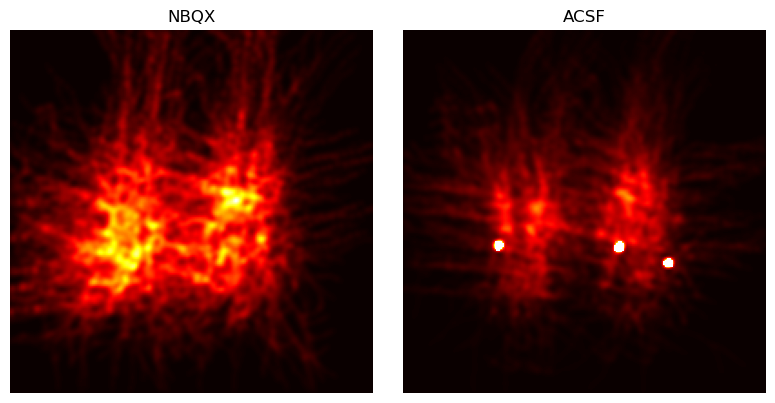

vmin_both: -0.0, vmax_both: 0.2914160490036011


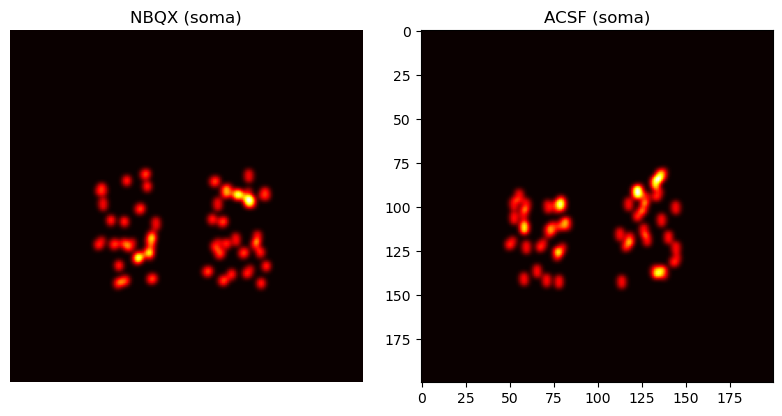

In [ ]:
start_time = 500

arr1, arr2 = None, None
arr12, arr22 = None, None
if type(compartment_selection) == str:
    arr1 = data_dir1 + 'composed_output/' + array_dict[compartment_selection]
    arr2 = data_dir2 + 'composed_output/' + array_dict[compartment_selection]
    arr1 = np.load(arr1, allow_pickle=True)
    arr2 = np.load(arr2, allow_pickle=True)
    if compartment_selection == 'all':
        arr1, arr2 = -arr1, -arr2
    print("loaded", arr1.shape, arr2.shape)
elif type(compartment_selection) == list:
    for comp in compartment_selection:
        arr1_ = data_dir1 + 'composed_output/' + array_dict[comp]
        arr2_ = data_dir2 + 'composed_output/' + array_dict[comp]
        arr1_ = np.load(arr1_)
        arr2_ = np.load(arr2_)
        if comp == 'all':
            arr1_, arr2_ = -arr1_, -arr2_
        if arr1 is None:
            arr1 = arr1_
            arr2 = arr2_
        else:
            arr1 += arr1_
            arr2 += arr2_

if type(compartment_selection2) == str:
    arr12 = data_dir1 + 'composed_output/' + array_dict[compartment_selection2]
    arr22 = data_dir2 + 'composed_output/' + array_dict[compartment_selection2]
    arr12 = np.load(arr12, allow_pickle=True)
    arr22 = np.load(arr22, allow_pickle=True)
    if compartment_selection2 == 'all':
        arr12, arr22 = -arr12, -arr22
    print("loaded", arr12.shape, arr22.shape)
elif type(compartment_selection2) == list:
    for comp in compartment_selection2:
        arr12_ = data_dir1 + 'composed_output/' + array_dict[comp]
        arr22_ = data_dir2 + 'composed_output/' + array_dict[comp]
        arr12_ = np.load(arr12_)
        arr22_ = np.load(arr22_)
        if comp == 'all':
            arr12_, arr22_ = -arr12_, -arr22_
        if arr12 is None:
            arr12 = arr12_
            arr22 = arr22_
        else:
            arr12 += arr12_
            arr22 += arr22_

arr1[:start_time, :, :] = 0  # remove the first x ms of data
arr2[:start_time, :, :] = 0  # remove the first x ms of data
arr12[:start_time, :, :] = 0  # remove the first x ms of data
arr22[:start_time, :, :] = 0  # remove the first x ms of data

arr1_cp = arr1.copy()
arr2_cp = arr2.copy()
arr12_cp = arr12.copy()
arr22_cp = arr22.copy()



# flatten every trace 
for y in range(arr1_cp.shape[1]):
    for x in range(arr1_cp.shape[2]):
        t1 = arr1_cp[start_time:, y, x]
        t2 = arr2_cp[start_time:, y, x]
        t12 = arr12_cp[start_time:, y, x]
        t22 = arr22_cp[start_time:, y, x]

        # flatten the traces from start_time to end
        # i.e. draw a line from the value at start_time to the value at end_time
        # and subtract that line from the trace
        x_ = np.array([start_time, arr1_cp.shape[0] - 1])
        y1 = np.array([t1[0], t1[-1]])
        y2 = np.array([t2[0], t2[-1]])
        y12 = np.array([t12[0], t12[-1]])
        y22 = np.array([t22[0], t22[-1]])

        coeffs1 = np.polyfit(x_, y1, 1)
        coeffs2 = np.polyfit(x_, y2, 1)
        coeffs12 = np.polyfit(x_, y12, 1)
        coeffs22 = np.polyfit(x_, y22, 1)

        trend1 = np.polyval(coeffs1, np.arange(arr1_cp.shape[0] - start_time)) + t1[0]
        trend2 = np.polyval(coeffs2, np.arange(arr2_cp.shape[0] - start_time)) + t2[0]
        trend12 = np.polyval(coeffs12, np.arange(arr12_cp.shape[0] - start_time)) + t12[0]
        trend22 = np.polyval(coeffs22, np.arange(arr22_cp.shape[0] - start_time)) + t22[0]
        arr1_cp[start_time:, y, x] = arr1_cp[start_time:, y, x] - trend1
        arr2_cp[start_time:, y, x] = arr2_cp[start_time:, y, x] - trend2
        arr12_cp[start_time:, y, x] = arr12_cp[start_time:, y, x] - trend12
        arr22_cp[start_time:, y, x] = arr22_cp[start_time:, y, x] - trend22

arr1_cp, arr2_cp = -arr1_cp, -arr2_cp
arr12_cp, arr22_cp = -arr12_cp, -arr22_cp

clip_val = 2
arr1_cp[arr1_cp > clip_val] = np.nan
arr2_cp[arr2_cp > clip_val] = np.nan
arr12_cp[arr12_cp > clip_val] = np.nan
arr22_cp[arr22_cp > clip_val] = np.nan

# plot the images
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
vmin_both = min(arr1_cp.min(), arr2_cp.min())
vmax_both = max(arr1_cp.max(), arr2_cp.max())
print(f'vmin_both: {vmin_both}, vmax_both: {vmax_both}')
ax[0].imshow(np.mean(arr1_cp, axis=0), cmap='hot') #, vmin=vmin_both, vmax=vmax_both)
ax[0].set_title(label1)
ax[0].axis('off')
ax[1].imshow(np.mean(arr2_cp, axis=0), cmap='hot') #, vmin=vmin_both, vmax=vmax_both)
ax[1].set_title(label2)
ax[1].axis('off')
plt.tight_layout()
plt.savefig(output_dir + f"final_images{data_dir1.split('/')[-2]}_and_{data_dir2.split('/')[-2]}_{comp_select_name}.png")
plt.show()
plt.close() 

# plot the images for the second compartment selection
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
vmin_both = min(arr12_cp.min(), arr22_cp.min())
vmax_both = max(arr12_cp.max(), arr22_cp.max())
print(f'vmin_both: {vmin_both}, vmax_both: {vmax_both}')
ax[0].imshow(np.mean(arr12_cp, axis=0), cmap='hot') #, vmin=vmin_both, vmax=vmax_both)
ax[0].set_title(label1 + f' ({compartment_selection2})')
ax[0].axis('off')
ax[1].imshow(np.mean(arr22_cp, axis=0), cmap='hot') #, vmin=vmin_both, vmax=vmax_both)
ax[1].set_title(label2 + f' ({compartment_selection2})')
ax[1].axis('off')
plt.tight_layout()
plt.savefig(output_dir + f"final_images_{data_dir1.split('/')[-2]}_and_{data_dir2.split('/')[-2]}_{comp_select_name2}.png")
plt.show()
plt.close()

ROI 0 at (x,y) = ( 114 , 32 )


C:\Users\jjudge3\AppData\Local\Temp\ipykernel_31720\2103031050.py:58: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[i_subplot].set_xticks([50, 70, 90], [0, 20, 40])


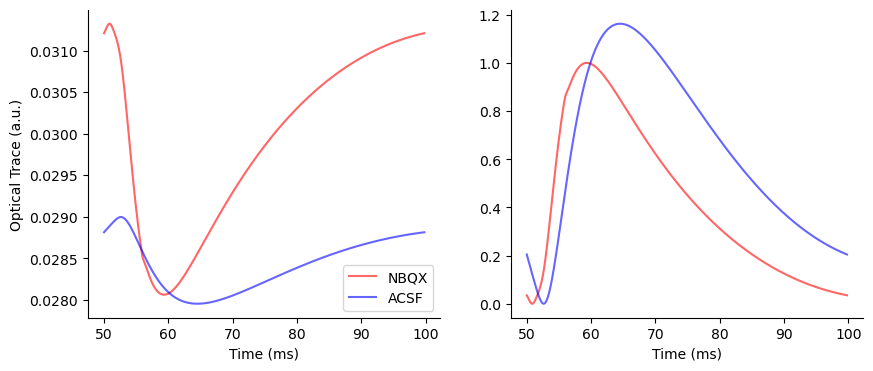

ROI 1 at (x,y) = ( 54 , 99 )


C:\Users\jjudge3\AppData\Local\Temp\ipykernel_31720\2103031050.py:58: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[i_subplot].set_xticks([50, 70, 90], [0, 20, 40])


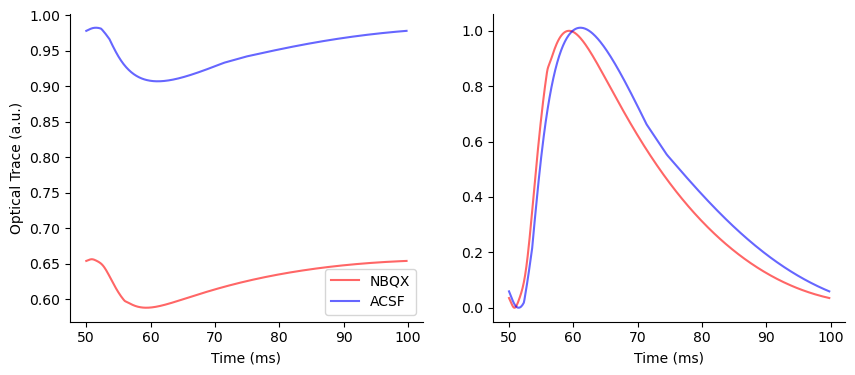

ROI 2 at (x,y) = ( 137 , 99 )


C:\Users\jjudge3\AppData\Local\Temp\ipykernel_31720\2103031050.py:58: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[i_subplot].set_xticks([50, 70, 90], [0, 20, 40])


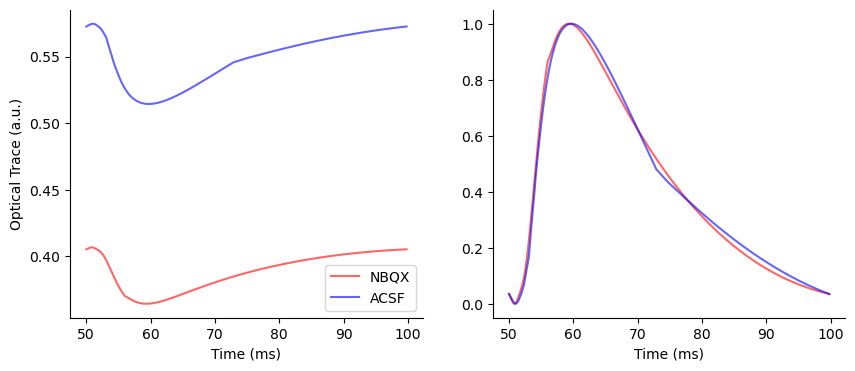

ROI 3 at (x,y) = ( 85 , 175 )


C:\Users\jjudge3\AppData\Local\Temp\ipykernel_31720\2103031050.py:58: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[i_subplot].set_xticks([50, 70, 90], [0, 20, 40])


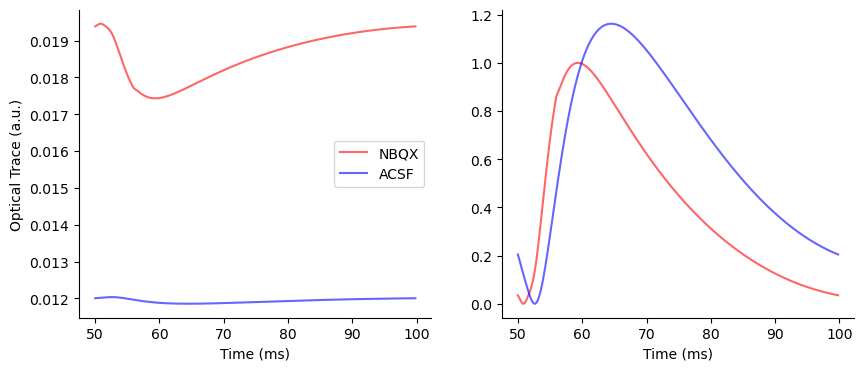

ROI 4 at (x,y) = ( 107 , 43 )


C:\Users\jjudge3\AppData\Local\Temp\ipykernel_31720\2103031050.py:58: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[i_subplot].set_xticks([50, 70, 90], [0, 20, 40])


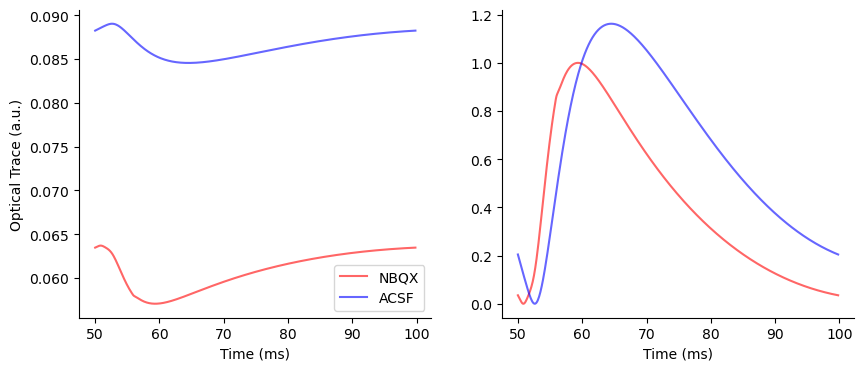

ROI 5 at (x,y) = ( 105 , 33 )


C:\Users\jjudge3\AppData\Local\Temp\ipykernel_31720\2103031050.py:58: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[i_subplot].set_xticks([50, 70, 90], [0, 20, 40])


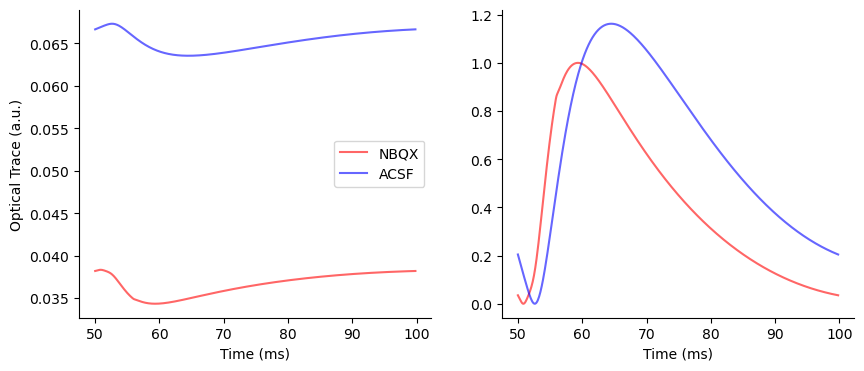

ROI 6 at (x,y) = ( 178 , 107 )


C:\Users\jjudge3\AppData\Local\Temp\ipykernel_31720\2103031050.py:58: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[i_subplot].set_xticks([50, 70, 90], [0, 20, 40])


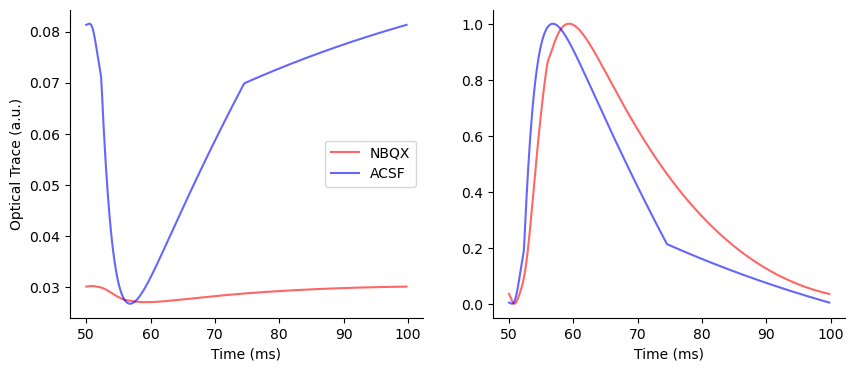

ROI 7 at (x,y) = ( 21 , 84 )


C:\Users\jjudge3\AppData\Local\Temp\ipykernel_31720\2103031050.py:58: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[i_subplot].set_xticks([50, 70, 90], [0, 20, 40])


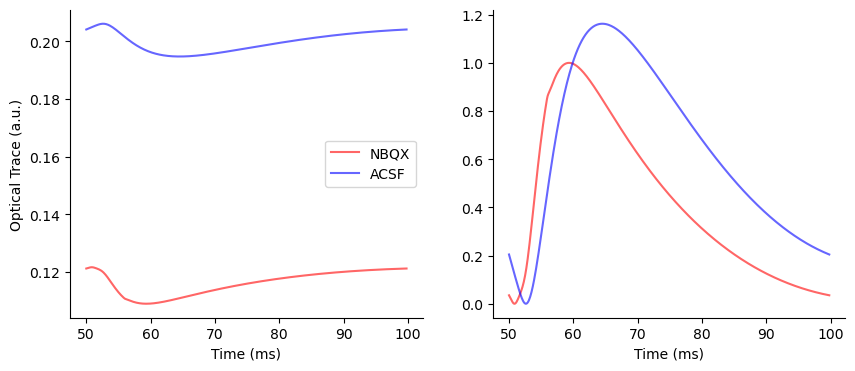

ROI 8 at (x,y) = ( 57 , 100 )


C:\Users\jjudge3\AppData\Local\Temp\ipykernel_31720\2103031050.py:58: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[i_subplot].set_xticks([50, 70, 90], [0, 20, 40])


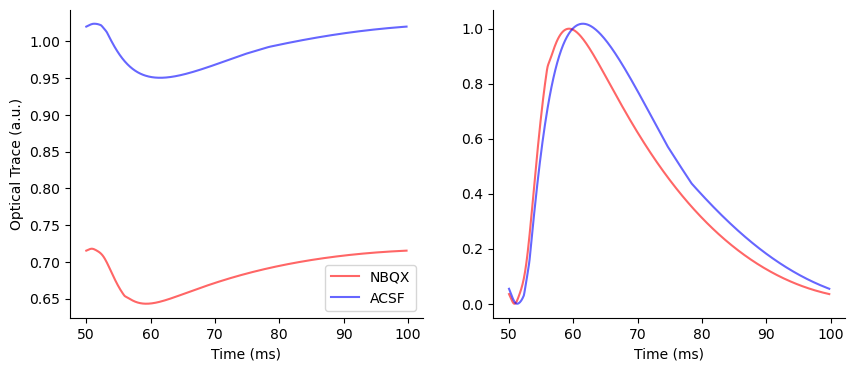

ROI 9 at (x,y) = ( 128 , 139 )


C:\Users\jjudge3\AppData\Local\Temp\ipykernel_31720\2103031050.py:58: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[i_subplot].set_xticks([50, 70, 90], [0, 20, 40])


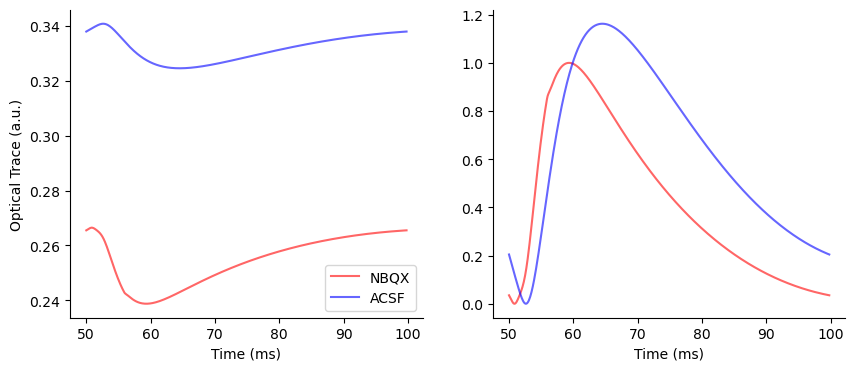

ROI 10 at (x,y) = ( 92 , 144 )


C:\Users\jjudge3\AppData\Local\Temp\ipykernel_31720\2103031050.py:58: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[i_subplot].set_xticks([50, 70, 90], [0, 20, 40])


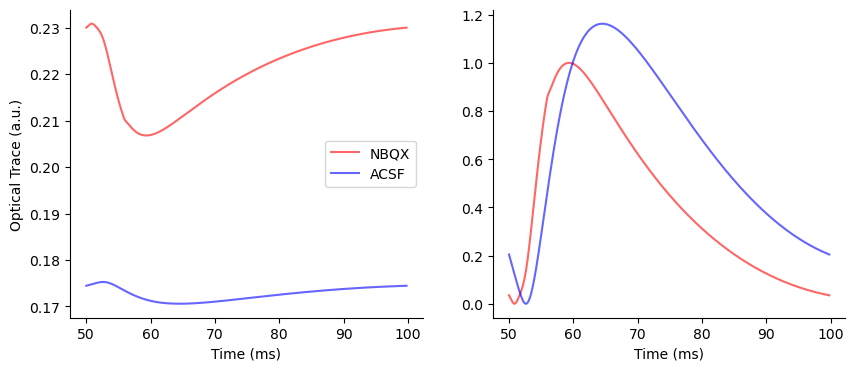

ROI 11 at (x,y) = ( 113 , 62 )


C:\Users\jjudge3\AppData\Local\Temp\ipykernel_31720\2103031050.py:58: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[i_subplot].set_xticks([50, 70, 90], [0, 20, 40])


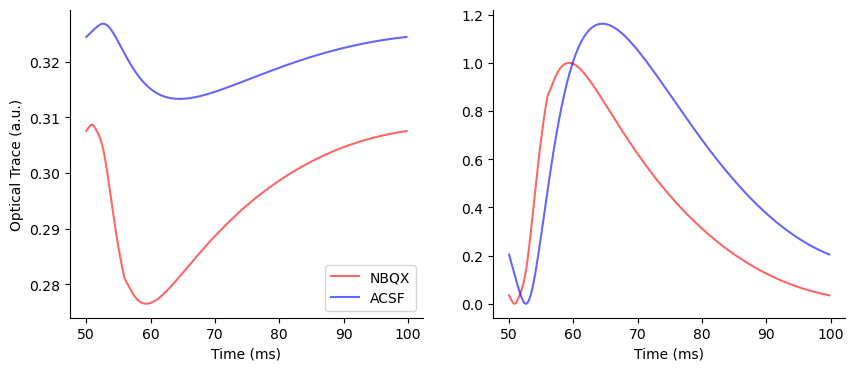

ROI 12 at (x,y) = ( 77 , 42 )


C:\Users\jjudge3\AppData\Local\Temp\ipykernel_31720\2103031050.py:58: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[i_subplot].set_xticks([50, 70, 90], [0, 20, 40])


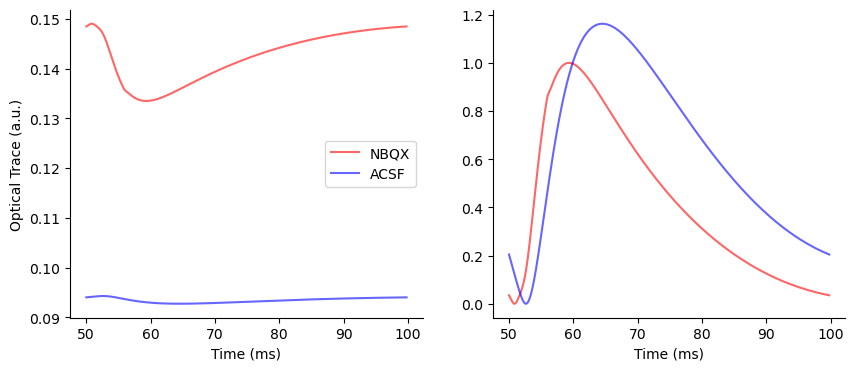

ROI 13 at (x,y) = ( 24 , 103 )


C:\Users\jjudge3\AppData\Local\Temp\ipykernel_31720\2103031050.py:58: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[i_subplot].set_xticks([50, 70, 90], [0, 20, 40])


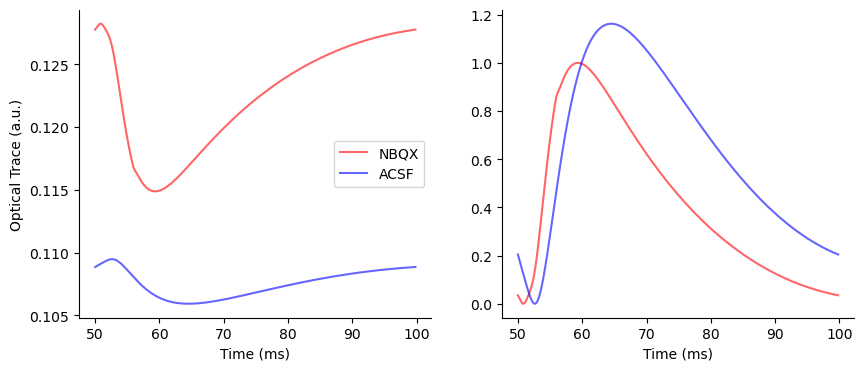

ROI 14 at (x,y) = ( 110 , 101 )


C:\Users\jjudge3\AppData\Local\Temp\ipykernel_31720\2103031050.py:58: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[i_subplot].set_xticks([50, 70, 90], [0, 20, 40])


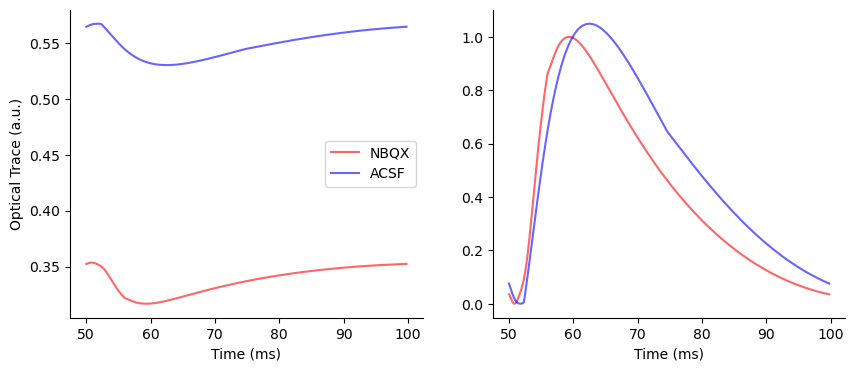

ROI 15 at (x,y) = ( 36 , 138 )


C:\Users\jjudge3\AppData\Local\Temp\ipykernel_31720\2103031050.py:58: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[i_subplot].set_xticks([50, 70, 90], [0, 20, 40])


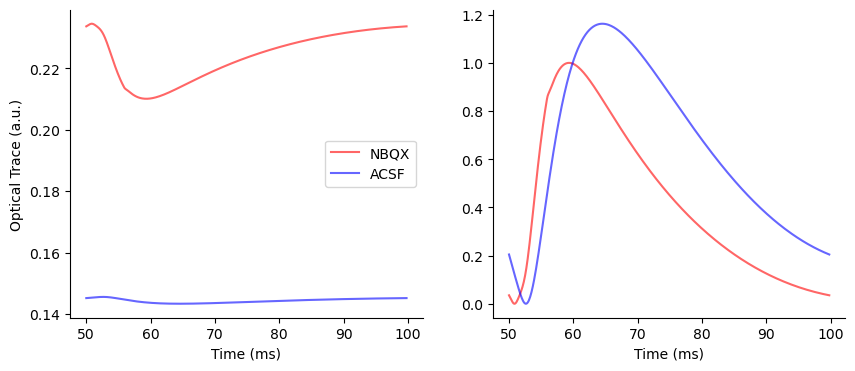

ROI 16 at (x,y) = ( 98 , 53 )


C:\Users\jjudge3\AppData\Local\Temp\ipykernel_31720\2103031050.py:58: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[i_subplot].set_xticks([50, 70, 90], [0, 20, 40])


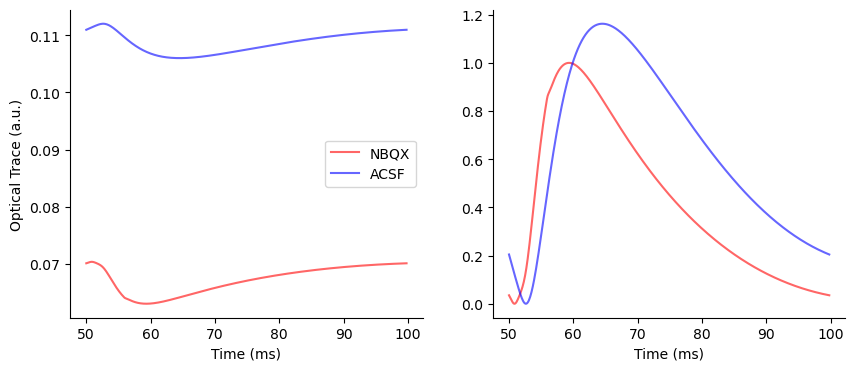

ROI 17 at (x,y) = ( 174 , 121 )


C:\Users\jjudge3\AppData\Local\Temp\ipykernel_31720\2103031050.py:58: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[i_subplot].set_xticks([50, 70, 90], [0, 20, 40])


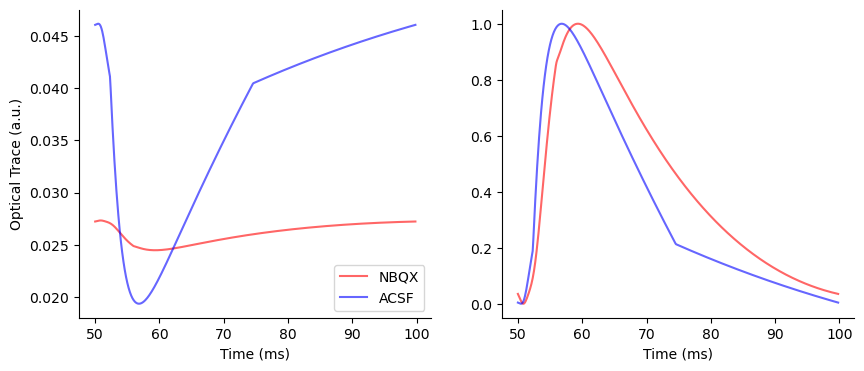

ROI 18 at (x,y) = ( 77 , 48 )


C:\Users\jjudge3\AppData\Local\Temp\ipykernel_31720\2103031050.py:58: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[i_subplot].set_xticks([50, 70, 90], [0, 20, 40])


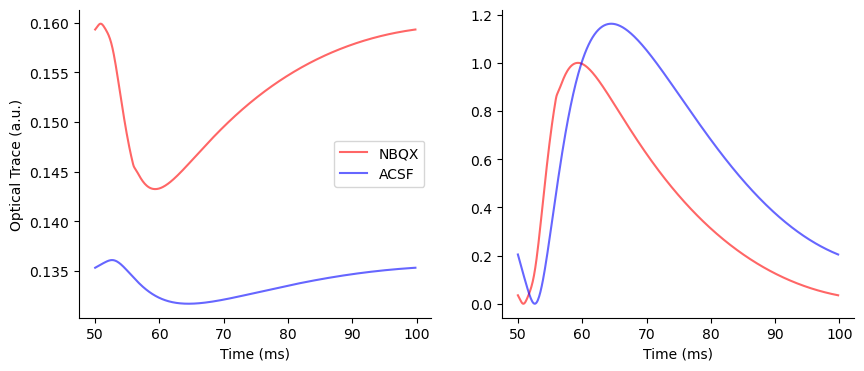

ROI 19 at (x,y) = ( 137 , 48 )


C:\Users\jjudge3\AppData\Local\Temp\ipykernel_31720\2103031050.py:58: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[i_subplot].set_xticks([50, 70, 90], [0, 20, 40])


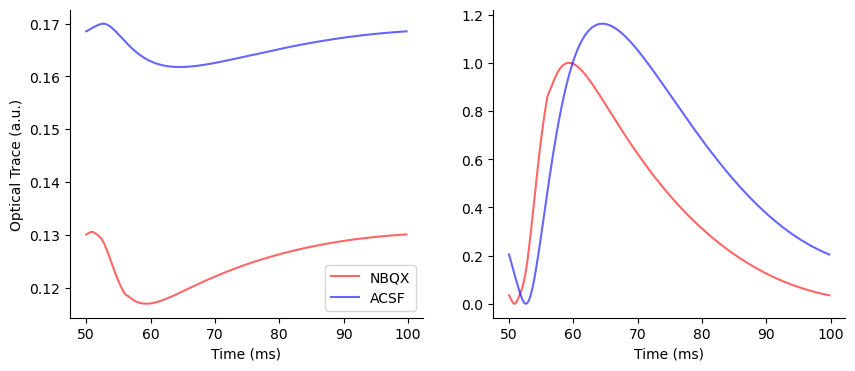

ROI 20 at (x,y) = ( 31 , 136 )


C:\Users\jjudge3\AppData\Local\Temp\ipykernel_31720\2103031050.py:58: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[i_subplot].set_xticks([50, 70, 90], [0, 20, 40])


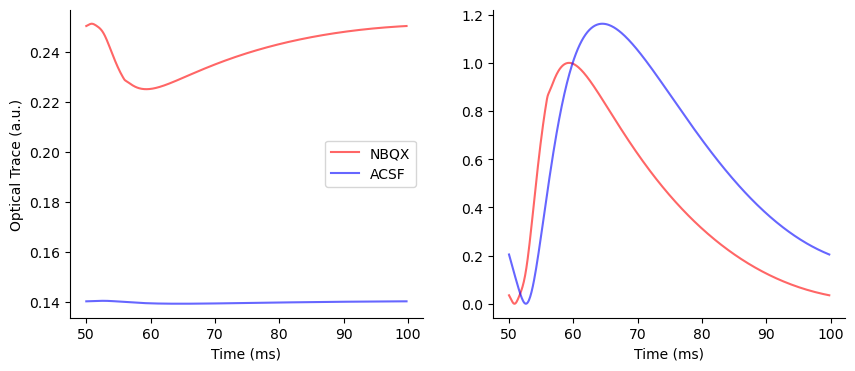

ROI 21 at (x,y) = ( 144 , 146 )


C:\Users\jjudge3\AppData\Local\Temp\ipykernel_31720\2103031050.py:58: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[i_subplot].set_xticks([50, 70, 90], [0, 20, 40])


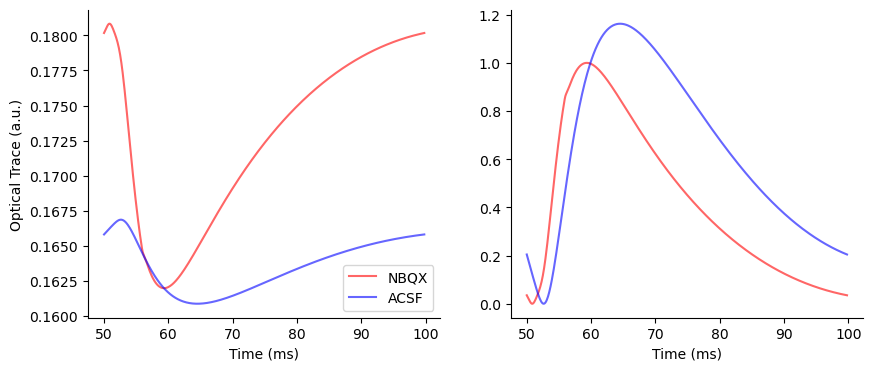

ROI 22 at (x,y) = ( 104 , 23 )


C:\Users\jjudge3\AppData\Local\Temp\ipykernel_31720\2103031050.py:58: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[i_subplot].set_xticks([50, 70, 90], [0, 20, 40])


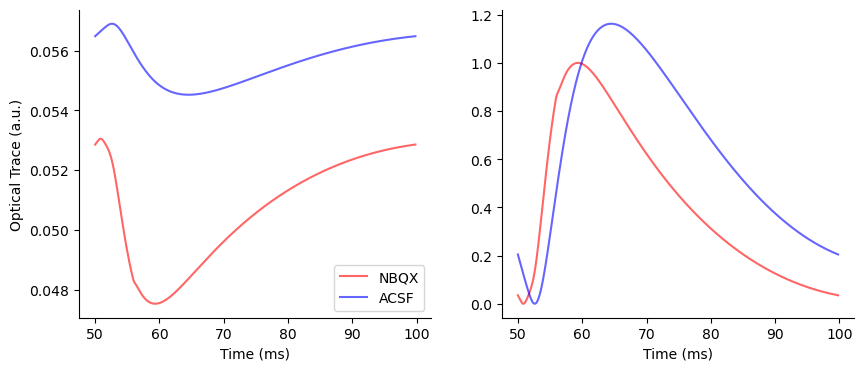

ROI 23 at (x,y) = ( 161 , 111 )


C:\Users\jjudge3\AppData\Local\Temp\ipykernel_31720\2103031050.py:58: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[i_subplot].set_xticks([50, 70, 90], [0, 20, 40])


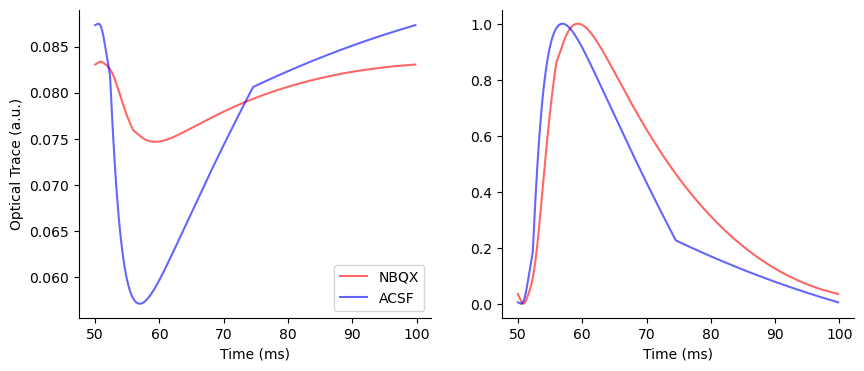

ROI 24 at (x,y) = ( 165 , 37 )


C:\Users\jjudge3\AppData\Local\Temp\ipykernel_31720\2103031050.py:58: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[i_subplot].set_xticks([50, 70, 90], [0, 20, 40])


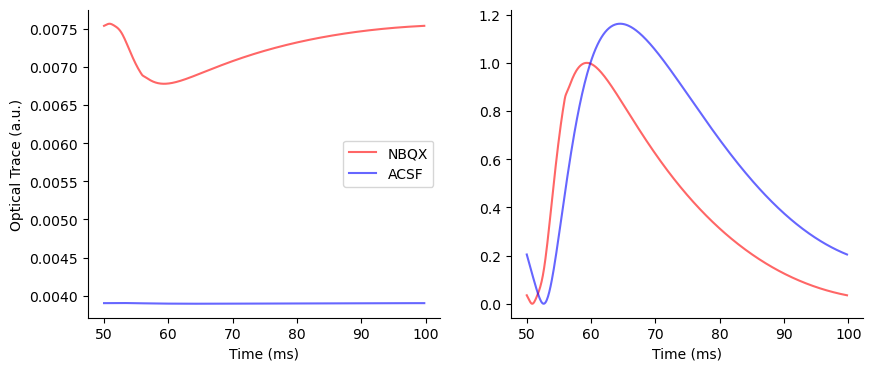

In [6]:
# and select single-pixel ROIs and plot their traces
num_rois = 25
random.seed(4322)

roi_x = random.choices(range(20, cam_width - 20), k=num_rois)
roi_y = random.choices(range(20, cam_height - 20), k=num_rois)
roi_traces1 = np.zeros((num_rois, arr1.shape[0]))
roi_traces2 = np.zeros((num_rois, arr2.shape[0]))
for i in range(num_rois):
    roi_traces1[i, :] = arr1[:, roi_y[i], roi_x[i]]
    roi_traces2[i, :] = arr2[:, roi_y[i], roi_x[i]]

    # flatten the traces from start_time to end
    # i.e. draw a line from the value at start_time to the value at end_time
    # and subtract that line from the trace
    x = np.array([start_time, arr1.shape[0] - 1])
    y1 = np.array([roi_traces1[i, start_time], roi_traces1[i, -1]])
    y2 = np.array([roi_traces2[i, start_time], roi_traces2[i, -1]])
    coeffs1 = np.polyfit(x, y1, 1)
    coeffs2 = np.polyfit(x, y2, 1)
    trend1 = np.polyval(coeffs1, np.arange(arr1.shape[0]))
    trend2 = np.polyval(coeffs2, np.arange(arr2.shape[0]))
    roi_traces1[i, :] = roi_traces1[i, :] - trend1
    roi_traces2[i, :] = roi_traces2[i, :] - trend2

# plot the traces on two separate plots
for i in range(num_rois):
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    last_headspace = 0
    print("ROI", i, "at (x,y) = (", roi_x[i], ",", roi_y[i], ")")
    #for i in range(num_rois):
    roi_trace = roi_traces1[i, :] - roi_traces1[i, :].min()  # shift to min of 0
    start_trace = np.where(time >= start_time * delta_t)[0][0]
    ax[0].plot(time[start_trace:], roi_trace[start_trace:] + last_headspace, color='red', alpha=0.6)
    last_headspace += roi_trace[start_trace:].max() * 0.5  # add half the max value as headspace
    #for i in range(num_rois):
    roi_trace = roi_traces2[i, :] - roi_traces2[i, :].min()  # shift to min of 0
    start_trace = np.where(time >= start_time * delta_t)[0][0]
    ax[0].plot(time[start_trace:], roi_trace[start_trace:] + last_headspace, color='blue', alpha=0.6)

    # at ax[1], we show the two traces overlaid and normalized to their own max
    last_headspace = 0
    roi_trace = -roi_traces1[i, :]
    # min-max normalize
    roi_trace = roi_trace - np.min(roi_trace)
    roi_trace = roi_trace / abs(-roi_trace[start_trace:start_trace+100]).max()  # normalize to own max
    start_trace = np.where(time >= start_time * delta_t)[0][0]
    ax[1].plot(time[start_trace:], roi_trace[start_trace:] + last_headspace, color='red', alpha=0.6)
    roi_trace = -roi_traces2[i, :]
    roi_trace = roi_trace - np.min(roi_trace)
    roi_trace = roi_trace / abs(-roi_trace[start_trace:start_trace+100]).max()  # normalize to own max
    start_trace = np.where(time >= start_time * delta_t)[0][0]
    ax[1].plot(time[start_trace:], roi_trace[start_trace:] + last_headspace, color='blue', alpha=0.6)

    ax[0].legend([label1, label2])
    for i_subplot in range(2):

        ax[i_subplot].set_xticks([50, 70, 90], [0, 20, 40])
        #ax[i_subplot].set_yticks([])
        #plt.ylim(-2, 0.3)
        # spines off
        ax[i_subplot].spines['top'].set_visible(False)
        ax[i_subplot].spines['right'].set_visible(False)
        ax[i_subplot].set_xlabel("Time (ms)")
        ax[0].set_ylabel("Optical Trace (a.u.)")
    plt.savefig(output_dir + f"roi_traces_{i}_{data_dir1.split('/')[-2]}_and_{data_dir2.split('/')[-2]}_{comp_select_name}.png")
    plt.show()

C:\Users\jjudge3\AppData\Local\Temp\ipykernel_31720\4018162552.py:57: RuntimeWarning: invalid value encountered in true_divide
  roi_trace1 = roi_trace1 / abs(-roi_trace1[start_trace:start_trace+100]).max()  # normalize to own max
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_31720\4018162552.py:61: RuntimeWarning: invalid value encountered in true_divide
  roi_trace2 = roi_trace2 / abs(-roi_trace2[start_trace:start_trace+100]).max()  # normalize to own max
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_31720\4018162552.py:65: RuntimeWarning: invalid value encountered in true_divide
  roi_trace12 = roi_trace12 / abs(-roi_trace12[start_trace:start_trace+100]).max()  # normalize to own max
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_31720\4018162552.py:69: RuntimeWarning: invalid value encountered in true_divide
  roi_trace22 = roi_trace22 / abs(-roi_trace22[start_trace:start_trace+100]).max()  # normalize to own max
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_31720\4018162552.py:57: 

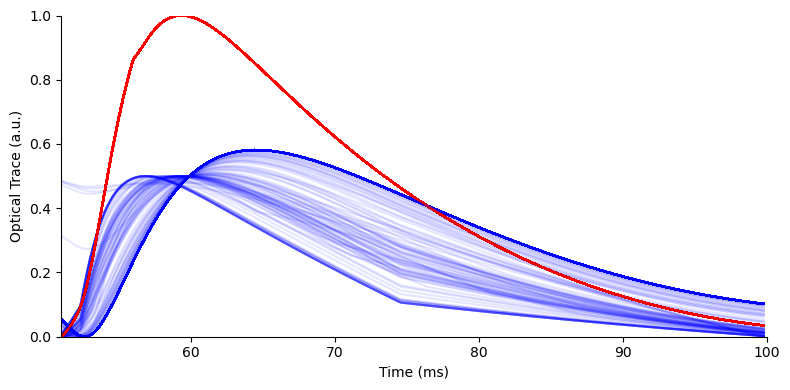

In [7]:
# we will make latency and half-width heatmaps now

half_width_map1 = np.zeros((cam_height, cam_width))
latency_map1 = np.zeros((cam_height, cam_width))
half_width_map2 = np.zeros((cam_height, cam_width))
latency_map2 = np.zeros((cam_height, cam_width))

half_width_map12 = np.zeros((cam_height, cam_width))
latency_map12 = np.zeros((cam_height, cam_width))
half_width_map22 = np.zeros((cam_height, cam_width))
latency_map22 = np.zeros((cam_height, cam_width))

amp_arr1 = np.zeros((cam_height, cam_width))
amp_arr2 = np.zeros((cam_height, cam_width))
amp_arr12 = np.zeros((cam_height, cam_width))
amp_arr22 = np.zeros((cam_height, cam_width))
fig, ax = plt.subplots(1, 1, figsize=(8, 4))

for y in range(arr1.shape[1]):
    for x in range(arr1.shape[2]):

        roi_trace1 = -arr1[:, y, x]
        roi_trace2 = -arr2[:, y, x]
        roi_trace12 = -arr12[:, y, x]
        roi_trace22 = -arr22[:, y, x]

        # flatten the traces from start_time to end
        # i.e. draw a line from the value at start_time to the value at end_time
        # and subtract that line from the trace
        x_ = np.array([start_time, arr1.shape[0] - 1])
        y1 = np.array([roi_trace1[start_time], roi_trace1[-1]])
        y2 = np.array([roi_trace2[start_time], roi_trace2[-1]])
        y12 = np.array([roi_trace12[start_time], roi_trace12[-1]])
        y22 = np.array([roi_trace22[start_time], roi_trace22[-1]])
        coeffs1 = np.polyfit(x_, y1, 1)
        coeffs2 = np.polyfit(x_, y2, 1)
        coeffs12 = np.polyfit(x_, y12, 1)
        coeffs22 = np.polyfit(x_, y22, 1)
        trend1 = np.polyval(coeffs1, np.arange(arr1.shape[0]))
        trend2 = np.polyval(coeffs2, np.arange(arr2.shape[0]))
        trend12 = np.polyval(coeffs12, np.arange(arr12.shape[0]))
        trend22 = np.polyval(coeffs22, np.arange(arr22.shape[0]))
        roi_trace1 = roi_trace1 - trend1
        roi_trace2 = roi_trace2 - trend2
        roi_trace12 = roi_trace12 - trend12
        roi_trace22 = roi_trace22 - trend22

        # populate amp arrays
        amp_arr1[y, x] = np.max(roi_trace1)
        amp_arr2[y, x] = np.max(roi_trace2)
        amp_arr12[y, x] = np.max(roi_trace12)
        amp_arr22[y, x] = np.max(roi_trace22)

        # before measuring properties, ensure the trace is min-max normalized
        
        roi_trace1 = roi_trace1 - np.min(roi_trace1)
        roi_trace1 = roi_trace1 / abs(-roi_trace1[start_trace:start_trace+100]).max()  # normalize to own max
        tp1 = TraceProperties(roi_trace1[start_trace:], start=0, width=400, int_pts=0.1) # int_pts = 0.1 ms per point

        roi_trace2 = roi_trace2 - np.min(roi_trace2)
        roi_trace2 = roi_trace2 / abs(-roi_trace2[start_trace:start_trace+100]).max()  # normalize to own max
        tp2 = TraceProperties(roi_trace2[start_trace:], start=0, width=400, int_pts=0.1)

        roi_trace12 = roi_trace12 - np.min(roi_trace12)
        roi_trace12 = roi_trace12 / abs(-roi_trace12[start_trace:start_trace+100]).max()  # normalize to own max
        tp12 = TraceProperties(roi_trace12[start_trace:], start=0, width=400, int_pts=0.1) # int_pts = 0.1 ms per point

        roi_trace22 = roi_trace22 - np.min(roi_trace22)
        roi_trace22 = roi_trace22 / abs(-roi_trace22[start_trace:start_trace+100]).max()  # normalize to own max
        tp22 = TraceProperties(roi_trace22[start_trace:], start=0, width=400, int_pts=0.1) # int_pts = 0.1 ms per point

        tp1.measure_properties()
        tp2.measure_properties()
        tp12.measure_properties()
        tp22.measure_properties()

        # show the traces and their properties for a few random pixels
        if random.random() < 0.01:
            start_trace = np.where(time >= start_time * delta_t)[0][0]
            ax.plot(time[start_trace:], roi_trace1[start_trace:], color='red', alpha=0.1)
            ax.plot(time[start_trace:], roi_trace2[start_trace:] * 0.5, color='blue', alpha=0.1)

            #print(f'{label1} Half-Width: {tp1.get_half_width()} ms, Latency: {tp1.get_half_amp_latency()} ms, '
            #      f'Max Amp Latency: {tp1.get_max_amp_latency()} ms, Max Amp: {tp1.get_max_amp()}')
            #print(f'{label2} Half-Width: {tp2.get_half_width()} ms, Latency: {tp2.get_half_amp_latency()} ms, '
            #      f'Max Amp Latency: {tp2.get_max_amp_latency()} ms, Max Amp: {tp2.get_max_amp()}')


        half_width_map1[y, x] = tp1.get_half_width()
        latency_map1[y, x] = tp1.get_half_amp_latency()
        half_width_map2[y, x] = tp2.get_half_width()
        latency_map2[y, x] = tp2.get_half_amp_latency()
        half_width_map12[y, x] = tp12.get_half_width()
        latency_map12[y, x] = tp12.get_half_amp_latency()
        half_width_map22[y, x] = tp22.get_half_width()
        latency_map22[y, x] = tp22.get_half_amp_latency()
ax.set_xticks([50, 70, 90], [0, 20, 40])
ax.set_xlim(51, 100)
ax.set_ylim(0, 1)
#ax[i_subplot].set_yticks([])
#plt.ylim(-2, 0.3)
# spines off
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel("Time (ms)")
ax.set_ylabel("Optical Trace (a.u.)")
plt.tight_layout()
plt.show()
plt.close()

vmin_both: nan, vmax_both: nan
vmin_both: 0.0, vmax_both: 6.619500588561883


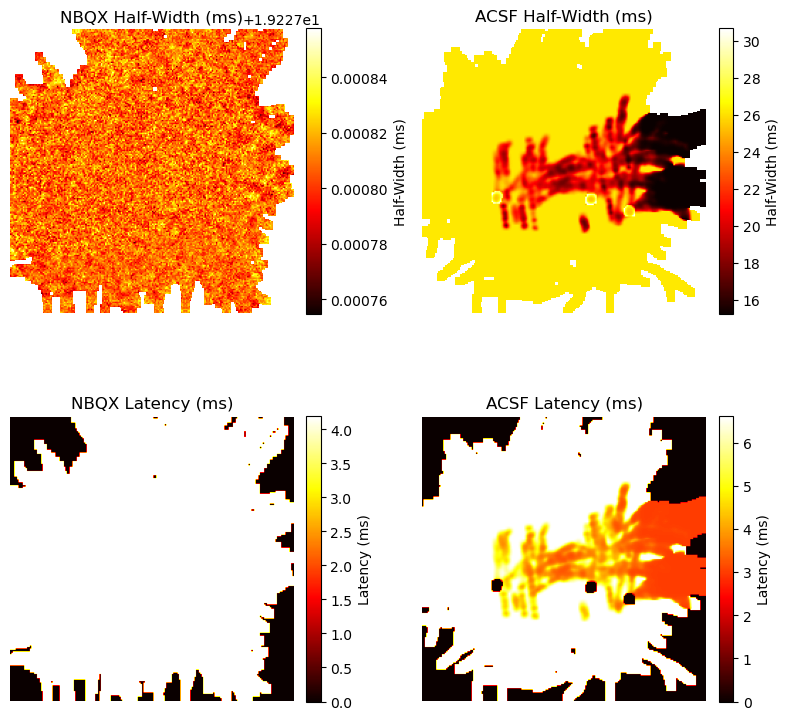

In [8]:
# plot the images of half-width and latency
fig, ax = plt.subplots(2, 2, figsize=(8, 8))
vmin_both = min(half_width_map1.min(), half_width_map2.min())
vmax_both = max(half_width_map1.max(), half_width_map2.max())
print(f'vmin_both: {vmin_both}, vmax_both: {vmax_both}')
ax[0, 0].imshow(half_width_map1, cmap='hot') #, vmin=vmin_both, vmax=vmax_both)
ax[0, 0].set_title(label1 + ' Half-Width (ms)')
ax[0, 0].axis('off')
ax[0, 1].imshow(half_width_map2, cmap='hot') #, vmin=vmin_both, vmax=vmax_both)
ax[0, 1].set_title(label2 + ' Half-Width (ms)')
ax[0, 1].axis('off')

vmin_both = min(latency_map1.min(), latency_map2.min())
vmax_both = max(latency_map1.max(), latency_map2.max())
print(f'vmin_both: {vmin_both}, vmax_both: {vmax_both}')
ax[1, 0].imshow(latency_map1, cmap='hot') #, vmin=vmin_both, vmax=vmax_both)
ax[1, 0].set_title(label1 + ' Latency (ms)')
ax[1, 0].axis('off')
ax[1, 1].imshow(latency_map2, cmap='hot') #, vmin=vmin_both, vmax=vmax_both)
ax[1, 1].set_title(label2 + ' Latency (ms)')
ax[1, 1].axis('off')

# show colorbars
cbar1 = fig.colorbar(ax[0, 0].images[0], ax=ax[0, 0], fraction=0.046, pad=0.04)
cbar1.set_label('Half-Width (ms)')
cbar2 = fig.colorbar(ax[0, 1].images[0], ax=ax[0, 1], fraction=0.046, pad=0.04)
cbar2.set_label('Half-Width (ms)')
cbar3 = fig.colorbar(ax[1, 0].images[0], ax=ax[1, 0], fraction=0.046, pad=0.04)
cbar3.set_label('Latency (ms)')
cbar4 = fig.colorbar(ax[1, 1].images[0], ax=ax[1, 1], fraction=0.046, pad=0.04)
cbar4.set_label('Latency (ms)')

plt.tight_layout()
plt.savefig(output_dir + f"final_images{data_dir1.split('/')[-2]}_and_{data_dir2.split('/')[-2]}_{comp_select_name}.png")
plt.show()
plt.close() 

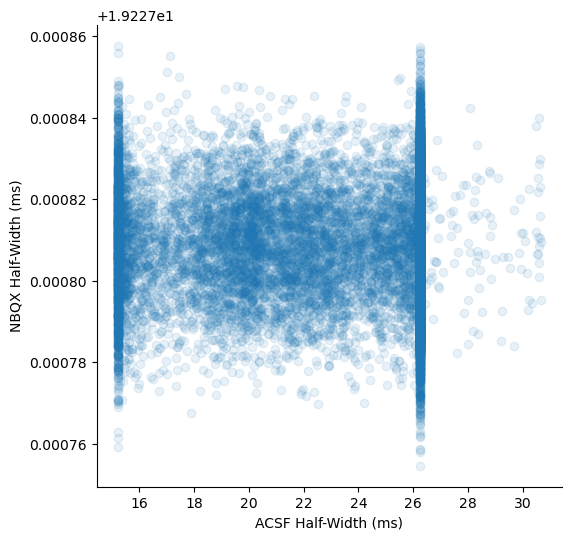

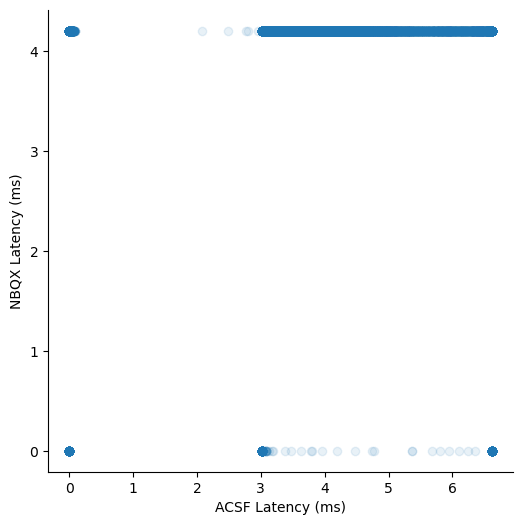

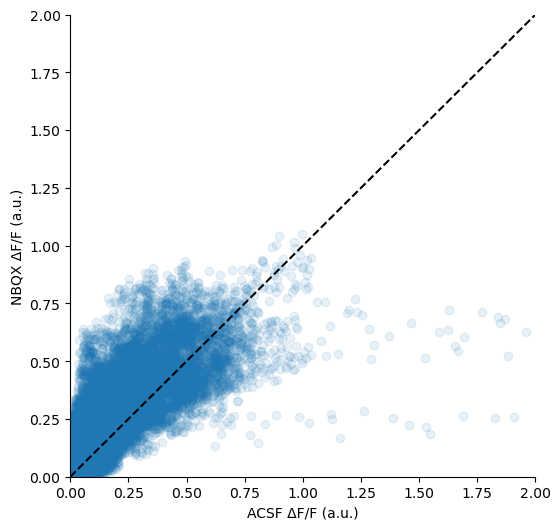

In [9]:
# are soma/dendrite half-widths changing in NBQX?
# look at correlation between: half-width, amplitude, latency in ACSF and in NBQX

# scatter: half-width in NBQX vs ACSF
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
plt.scatter(half_width_map2.flatten(), half_width_map1.flatten(), alpha=0.1)
plt.xlabel(label2 + ' Half-Width (ms)')
plt.ylabel(label1 + ' Half-Width (ms)')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.savefig(output_dir + f"halfwidth_scatter_{data_dir1.split('/')[-2]}_and_{data_dir2.split('/')[-2]}_{comp_select_name}.png")
plt.show()
plt.close()


# are soma/dendrite half-widths changing in NBQX?
# look at correlation between: half-width, amplitude, latency in ACSF and in NBQX

# scatter: half-width in NBQX vs ACSF
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

plt.scatter(latency_map2.flatten(), latency_map1.flatten(), alpha=0.1)
plt.xlabel(label2 + ' Latency (ms)')
plt.ylabel(label1 + ' Latency (ms)')
#plt.xlim(1.8, 2.2)
#plt.ylim(2.5, 6.5)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
#plt.plot([0, 10], [0, 10], color='black', linestyle='--')
plt.savefig(output_dir + f"latency_scatter_{data_dir1.split('/')[-2]}_and_{data_dir2.split('/')[-2]}_{comp_select_name}.png")
plt.show()
plt.close()

# scatter: amp in NBQX vs ACSF
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
plt.scatter(amp_arr2.flatten(), amp_arr1.flatten(), alpha=0.1)
plt.xlabel(label2 + ' ΔF/F (a.u.)')
plt.ylabel(label1 + ' ΔF/F (a.u.)')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.plot([0, 2], [0, 2], color='black', linestyle='--')
plt.xlim(0, 2)
plt.ylim(0, 2)
plt.savefig(output_dir + f"amplitude_scatter_{data_dir1.split('/')[-2]}_and_{data_dir2.split('/')[-2]}_{comp_select_name}.png")
plt.show()
plt.close()

Mean NBQX/ACSF amplitude ratio: 3.130 ± 0.043 (n=30385)
Appended to C:/Users/jjudge3/Desktop/neuron docker/composed_results/partial_nbqx_fractions_ratios.csv


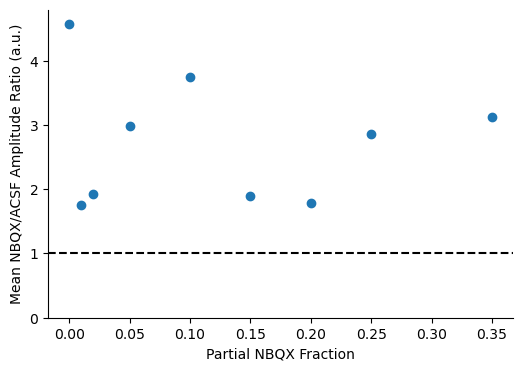

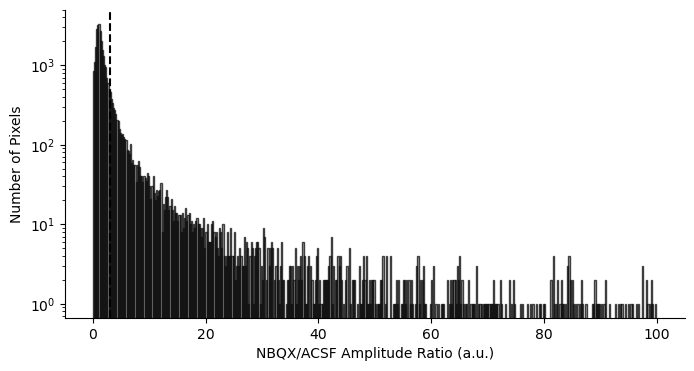

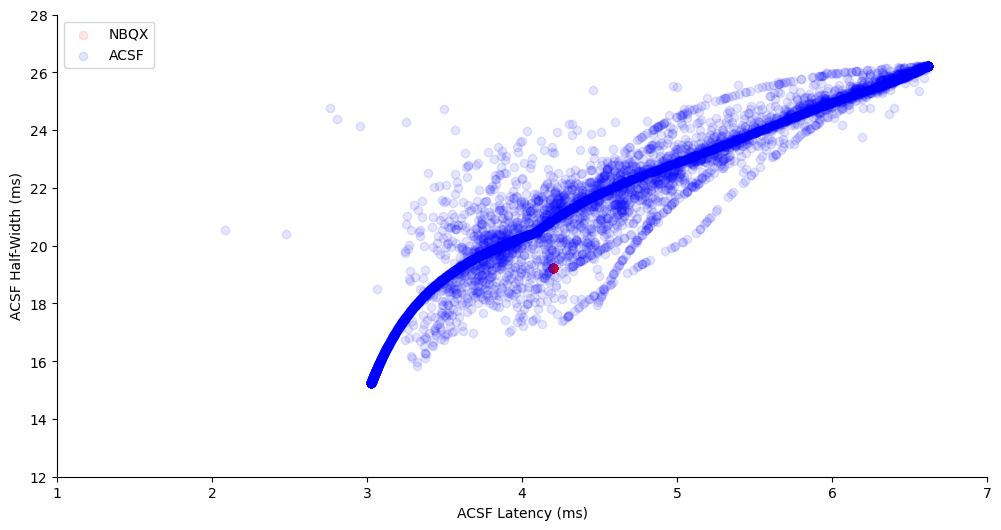

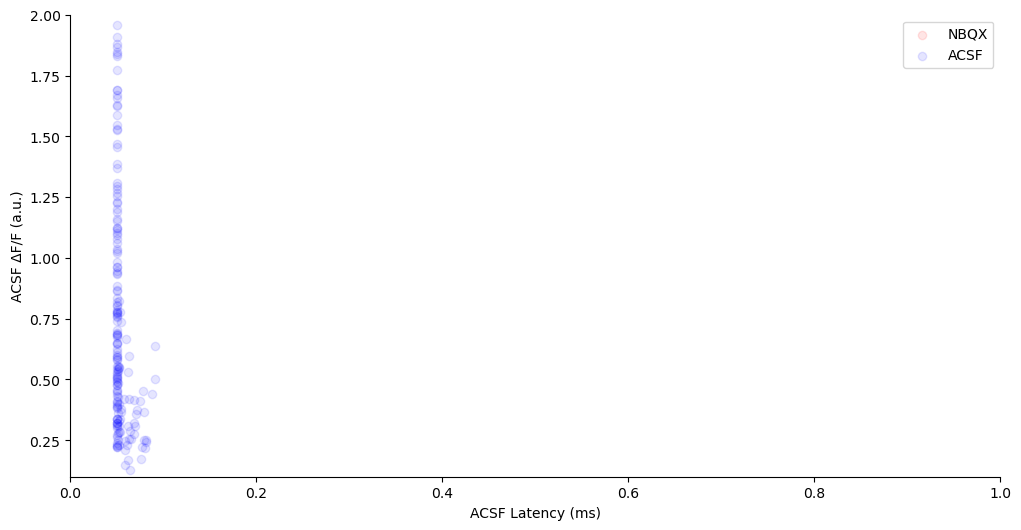

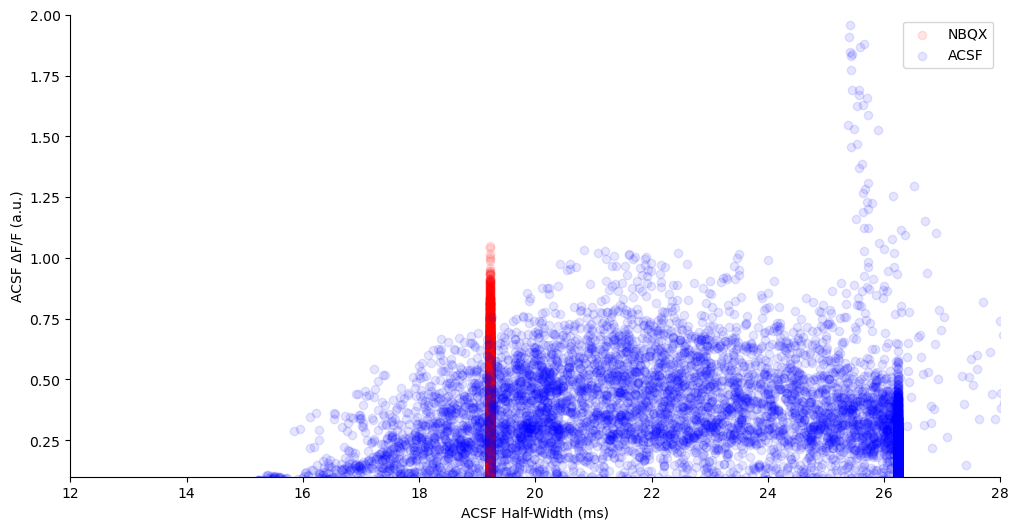

In [10]:
# calculate mean NBQX/ACSF amplitude ratio and sem
amp_ratio_arr = amp_arr1[amp_arr2 > 0] / amp_arr2[amp_arr2 > 0]
amp_ratio_arr = amp_ratio_arr[~np.isnan(amp_ratio_arr) & (amp_ratio_arr < 100) & (amp_ratio_arr > 0)]
mean_amp_ratio = np.mean(amp_ratio_arr)
sem_amp_ratio = np.std(amp_ratio_arr) / np.sqrt(len(amp_ratio_arr))
print(f'Mean {label1}/{label2} amplitude ratio: {mean_amp_ratio:.3f} ± {sem_amp_ratio:.3f} (n={len(amp_ratio_arr)})')

# open the partial NBQX fractions ratio file and append this value if not already present
if partial_nbqx_fractions_ratio_file is not None:
    if os.path.exists(partial_nbqx_fractions_ratio_file):
        with open(partial_nbqx_fractions_ratio_file, 'r') as f:
            lines = f.readlines()
        existing_fractions = [float(line.split(',')[0]) for line in lines[1:]]
        if nbqx_fraction not in existing_fractions:
            with open(partial_nbqx_fractions_ratio_file, 'a') as f:
                f.write(f'{nbqx_fraction},{mean_amp_ratio},{sem_amp_ratio},{len(amp_ratio_arr)}\n')
            print(f'Appended to {partial_nbqx_fractions_ratio_file}')
        else:
            print(f'Fraction {nbqx_fraction} already present in {partial_nbqx_fractions_ratio_file}, not appending.')
    else:
        with open(partial_nbqx_fractions_ratio_file, 'w') as f:
            f.write('Partial_NBQX_Fraction,Mean_Amplitude_Ratio,SEM_Amplitude_Ratio,N_Pixels\n')
            f.write(f'{nbqx_fraction},{mean_amp_ratio},{sem_amp_ratio},{len(amp_ratio_arr)}\n')
        print(f'Created and wrote to {partial_nbqx_fractions_ratio_file}')

# plot partial NBQX fractions vs amplitude ratios if file exists
if partial_nbqx_fractions_ratio_file is not None:
    if os.path.exists(partial_nbqx_fractions_ratio_file):
        fractions = []
        mean_ratios = []
        sem_ratios = []
        with open(partial_nbqx_fractions_ratio_file, 'r') as f:
            lines = f.readlines()
        for line in lines[1:]:
            parts = line.strip().split(',')
            fractions.append(float(parts[0]))
            mean_ratios.append(float(parts[1]))
            sem_ratios.append(float(parts[2]))
        fig, ax = plt.subplots(1, 1, figsize=(6, 4))
        plt.errorbar(fractions, mean_ratios, 
                     yerr=sem_ratios, fmt='o', color='tab:blue', ecolor='lightgray', elinewidth=3, capsize=0)
        plt.xlabel('Partial NBQX Fraction')
        plt.ylabel(f'Mean {label1}/{label2} Amplitude Ratio (a.u.)')
        # spines off
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        # horizontal line at y=1
        plt.axhline(y=1, color='black', linestyle='--')
        plt.ylim(0, None)
        nbqx_fraction_output_dir = partial_nbqx_fractions_ratio_file.split('partial_nbqx_fractions_ratios')[0]
        plt.savefig(nbqx_fraction_output_dir + f"partial_nbqx_fraction_vs_amplitude_ratio.png")
        plt.show()
        plt.close()

# plot histogram of amp_ratios, y axis log scale
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
plt.hist(amp_ratio_arr.flatten(), bins=500, color='gray', edgecolor='black', alpha=0.7)
plt.yscale('log')
plt.xlabel(f'{label1}/{label2} Amplitude Ratio (a.u.)')
plt.ylabel('Number of Pixels')
# spines off
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# vertical line at amp_ratio = 1
plt.axvline(x=mean_amp_ratio, color='black', linestyle='--', label=f'Mean Ratio = {mean_amp_ratio:.3f}')
plt.savefig(output_dir + f"amplitude_ratio_histogram_{data_dir1.split('/')[-2]}_and_{data_dir2.split('/')[-2]}_{comp_select_name}.png")
plt.show()
plt.close()

# latency vs half-width in ACSF (rigth panel) and NBQX (left panel, red)
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
vmin_latency = 1
vmax_latency = 7
vmin_halfwidth = 12
vmax_halfwidth = 28
plt.xlim(vmin_latency, vmax_latency)
plt.ylim(vmin_halfwidth, vmax_halfwidth)
plt.scatter(latency_map1.flatten(), half_width_map1.flatten(), alpha=0.1, color='red')
plt.xlabel(label1 + ' Latency (ms)')
plt.ylabel(label1 + ' Half-Width (ms)')
plt.scatter(latency_map2.flatten(), half_width_map2.flatten(), alpha=0.1, color='blue')
plt.xlabel(label2 + ' Latency (ms)')
plt.ylabel(label2 + ' Half-Width (ms)')
plt.xlim(vmin_latency, vmax_latency)
plt.ylim(vmin_halfwidth, vmax_halfwidth)
plt.legend([label1, label2])
# spines off
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.savefig(output_dir + f"latency_vs_halfwidth_{data_dir1.split('/')[-2]}_and_{data_dir2.split('/')[-2]}_{comp_select_name}.png")
plt.show()
plt.close()

# latency vs amplitude in ACSF (rigth panel) and NBQX (left panel, red)
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
vmin_latency = None #1
vmax_latency = None #7
vmin_amplitude = 0.1
vmax_amplitude = 2.0
plt.xlim(vmin_latency, vmax_latency)
plt.ylim(vmin_amplitude, vmax_amplitude)
plt.scatter(latency_map1.flatten(), amp_arr1.flatten(), alpha=0.1, color='red')
plt.xlabel(label1 + ' Latency (ms)')
plt.ylabel(label1 + ' ΔF/F (a.u.)')
plt.scatter(latency_map2.flatten(), amp_arr2.flatten(), alpha=0.1, color='blue')
plt.xlabel(label2 + ' Latency (ms)')
plt.ylabel(label2 + ' ΔF/F (a.u.)')
plt.xlim(vmin_latency, vmax_latency)
plt.ylim(vmin_amplitude, vmax_amplitude)
plt.legend([label1, label2])
# spines off
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.savefig(output_dir + f"latency_vs_amplitude_{data_dir1.split('/')[-2]}_and_{data_dir2.split('/')[-2]}_{comp_select_name}.png")
plt.show()
plt.close()

# halfwidth vs amplitude in ACSF (rigth panel) and NBQX (left panel, red)
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
vmin_halfwidth = 12
vmax_halfwidth = 28
vmin_amplitude = 0.1
vmax_amplitude = 2.0
plt.xlim(vmin_halfwidth, vmax_halfwidth)
plt.ylim(vmin_amplitude, vmax_amplitude)
plt.scatter(half_width_map1.flatten(), amp_arr1.flatten(), alpha=0.1, color='red')
plt.xlabel(label1 + ' Half-Width (ms)')
plt.ylabel(label1 + ' ΔF/F (a.u.)')
plt.scatter(half_width_map2.flatten(), amp_arr2.flatten(), alpha=0.1, color='blue')
plt.xlabel(label2 + ' Half-Width (ms)')
plt.ylabel(label2 + ' ΔF/F (a.u.)')
plt.xlim(vmin_halfwidth, vmax_halfwidth)
plt.ylim(vmin_amplitude, vmax_amplitude)
plt.legend([label1, label2])
# spines off
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.savefig(output_dir + f"halfwidth_vs_amplitude_{data_dir1.split('/')[-2]}_and_{data_dir2.split('/')[-2]}_{comp_select_name}.png")
plt.show()
plt.close()




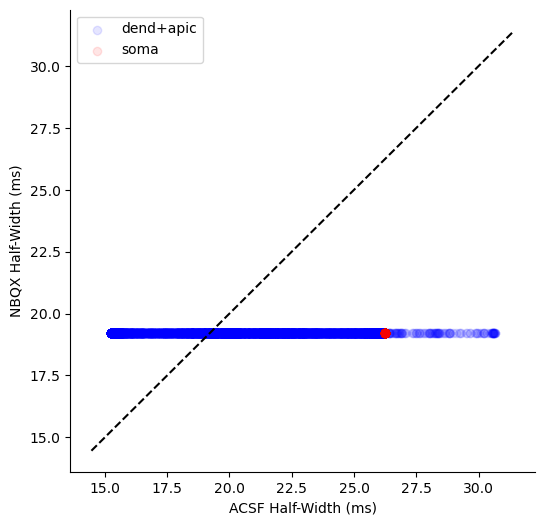

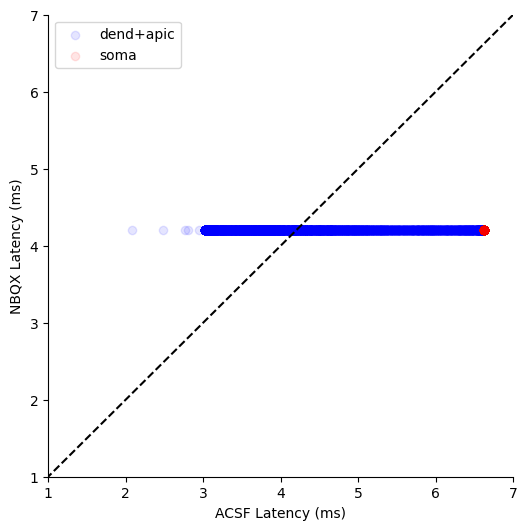

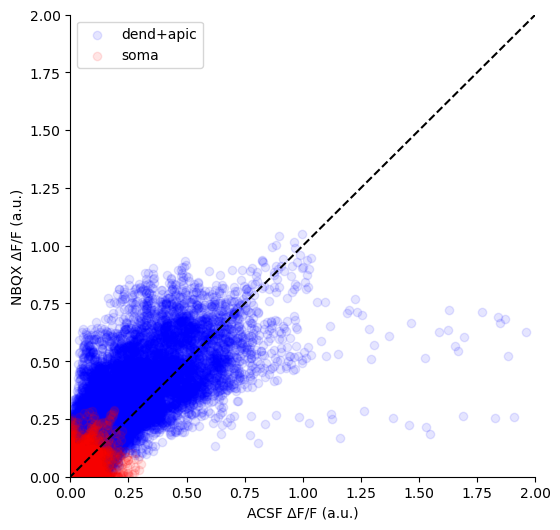

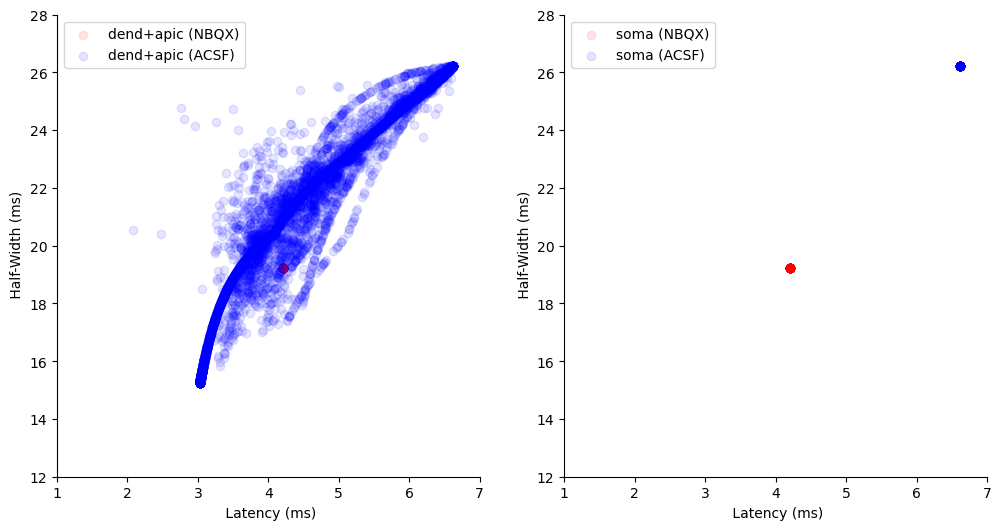

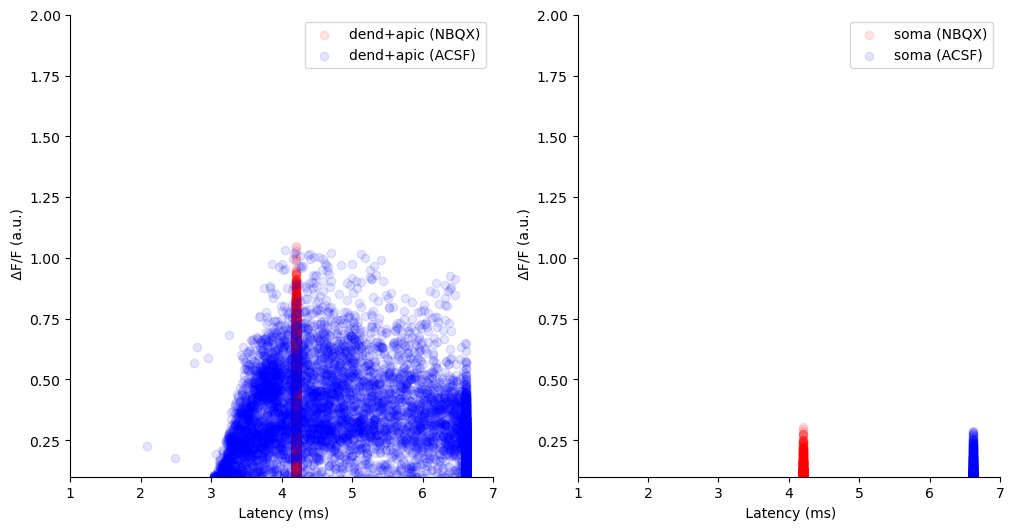

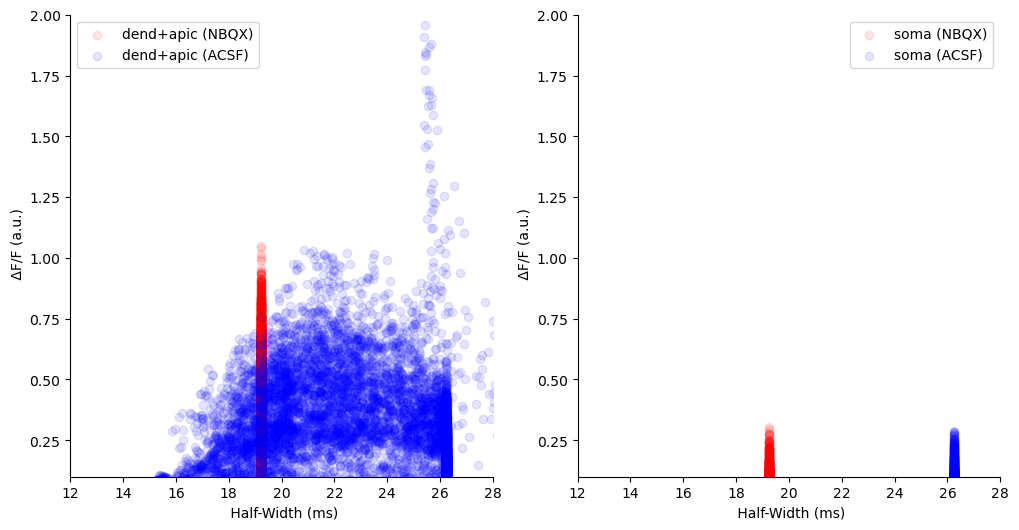

In [11]:
# are soma/dendrite half-widths changing in NBQX?
# look at correlation between: half-width, amplitude, latency in ACSF and in NBQX
vmin_latency = 1
vmax_latency = 7
vmin_halfwidth = 12
vmax_halfwidth = 28
vmin_amplitude = 0.1
vmax_amplitude = 2.0

# scatter: half-width in NBQX vs ACSF
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
plt.scatter(half_width_map2.flatten(), half_width_map1.flatten(), alpha=0.1, color='blue', label=comp_select_label)
plt.scatter(half_width_map22.flatten(), half_width_map12.flatten(), alpha=0.1, color='red', label=comp_select_label2)
plt.legend()
plt.xlabel(label2 + ' Half-Width (ms)')
plt.ylabel(label1 + ' Half-Width (ms)')
# unity line
plt_min_x = plt.gca().get_xlim()[0]
plt_max_x = plt.gca().get_xlim()[1]
line_min = min(plt_min_x, plt.gca().get_ylim()[0])
line_max = max(plt_max_x, plt.gca().get_ylim()[1])
plt.plot([line_min, line_max], [line_min, line_max], color='black', linestyle='--')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.savefig(output_dir + f"halfwidth_scatter_{data_dir1.split('/')[-2]}_and_{data_dir2.split('/')[-2]}_{comp_select_name}_vs_{comp_select_name2}.png")
plt.show()
plt.close()


# are soma/dendrite half-widths changing in NBQX?
# look at correlation between: half-width, amplitude, latency in ACSF and in NBQX

# scatter: half-width in NBQX vs ACSF
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
plt.scatter(latency_map2.flatten(), latency_map1.flatten(), alpha=0.1, color='blue', label=comp_select_label)
plt.scatter(latency_map22.flatten(), latency_map12.flatten(), alpha=0.1, color='red', label=comp_select_label2)
plt.legend()
plt.xlabel(label2 + ' Latency (ms)')
plt.ylabel(label1 + ' Latency (ms)')
# unity line
plt_min_x = plt.gca().get_xlim()[0]
plt_max_x = plt.gca().get_xlim()[1]
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xlim(vmin_latency, vmax_latency)
plt.ylim(vmin_latency, vmax_latency)
line_min = min(plt_min_x, plt.gca().get_ylim()[0])
line_max = max(plt_max_x, plt.gca().get_ylim()[1])
plt.plot([line_min, line_max], [line_min, line_max], color='black', linestyle='--')
plt.savefig(output_dir + f"latency_scatter_{data_dir1.split('/')[-2]}_and_{data_dir2.split('/')[-2]}_{comp_select_name}_vs_{comp_select_name2}.png")
plt.show()
plt.close()

# scatter: amp in NBQX vs ACSF
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
plt.scatter(amp_arr2.flatten(), amp_arr1.flatten(), alpha=0.1, color='blue', label=comp_select_label)
plt.scatter(amp_arr12.flatten(), amp_arr22.flatten(), alpha=0.1, color='red', label=comp_select_label2)
plt.legend()
plt.xlabel(label2 + ' ΔF/F (a.u.)')
plt.ylabel(label1 + ' ΔF/F (a.u.)')
# unity line
plt_min_x = plt.gca().get_xlim()[0]
plt_max_x = plt.gca().get_xlim()[1]
line_min = min(plt_min_x, plt.gca().get_ylim()[0])
line_max = max(plt_max_x, plt.gca().get_ylim()[1])
plt.plot([line_min, line_max], [line_min, line_max], color='black', linestyle='--')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xlim(0, 2)
plt.ylim(0, 2)
plt.savefig(output_dir + f"amplitude_scatter_{data_dir1.split('/')[-2]}_and_{data_dir2.split('/')[-2]}_{comp_select_name}_vs_{comp_select_name2}.png")
plt.show()
plt.close()

# latency vs half-width in ACSF (rigth panel) and NBQX (left panel, red)
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

for a in ax:
    a.set_xlim(vmin_latency, vmax_latency)
    a.set_ylim(vmin_halfwidth, vmax_halfwidth)
    a.set_xlabel(' Latency (ms)')
    a.set_ylabel(' Half-Width (ms)')
ax[0].scatter(latency_map1.flatten(), half_width_map1.flatten(), alpha=0.1, color='red', label=comp_select_label + ' (NBQX)')
ax[0].scatter(latency_map2.flatten(), half_width_map2.flatten(), alpha=0.1, color='blue',  label=comp_select_label + ' (ACSF)')
ax[1].scatter(latency_map12.flatten(), half_width_map12.flatten(), alpha=0.1, color='red', label=comp_select_label2 + ' (NBQX)')
ax[1].scatter(latency_map22.flatten(), half_width_map22.flatten(), alpha=0.1, color='blue',  label=comp_select_label2 + ' (ACSF)')

ax[0].legend([comp_select_label + ' (NBQX)', comp_select_label + ' (ACSF)'])
ax[1].legend([comp_select_label2 + ' (NBQX)', comp_select_label2 + ' (ACSF)'])  
for a in ax:
    a.set_xlim(vmin_latency, vmax_latency)
    a.set_ylim(vmin_halfwidth, vmax_halfwidth)

    # spines off
    a.spines['top'].set_visible(False)
    a.spines['right'].set_visible(False)

plt.savefig(output_dir + f"latency_vs_halfwidth_{data_dir1.split('/')[-2]}_and_{data_dir2.split('/')[-2]}_{comp_select_name}_vs_{comp_select_name2}.png")
plt.show()
plt.close()

# latency vs amplitude in ACSF (rigth panel) and NBQX (left panel, red)
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
for a in ax:
    a.set_xlim(vmin_latency, vmax_latency)
    a.set_ylim(vmin_amplitude, vmax_amplitude)
    a.set_xlabel(' Latency (ms)')
    a.set_ylabel(' ΔF/F (a.u.)')
ax[0].scatter(latency_map1.flatten(), amp_arr1.flatten(), alpha=0.1, color='red', label=comp_select_label + ' (NBQX)')
ax[0].scatter(latency_map2.flatten(), amp_arr2.flatten(), alpha=0.1, color='blue', label=comp_select_label + ' (ACSF)')
ax[1].scatter(latency_map12.flatten(), amp_arr12.flatten(), alpha=0.1, color='red', label=comp_select_label2 + ' (NBQX)')
ax[1].scatter(latency_map22.flatten(), amp_arr22.flatten(), alpha=0.1, color='blue', label=comp_select_label2 + ' (ACSF)')
ax[0].legend([comp_select_label + ' (NBQX)', comp_select_label + ' (ACSF)'])
ax[1].legend([comp_select_label2 + ' (NBQX)', comp_select_label2 + ' (ACSF)'])

for a in ax:
    a.set_xlim(vmin_latency, vmax_latency)
    a.set_ylim(vmin_amplitude, vmax_amplitude)
    # spines off
    a.spines['top'].set_visible(False)
    a.spines['right'].set_visible(False)
plt.savefig(output_dir + f"latency_vs_amplitude_{data_dir1.split('/')[-2]}_and_{data_dir2.split('/')[-2]}_{comp_select_name}_vs_{comp_select_name2}.png")
plt.show()
plt.close()

# halfwidth vs amplitude in ACSF (rigth panel) and NBQX (left panel, red)
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
vmin_halfwidth = 12
vmax_halfwidth = 28
vmin_amplitude = 0.1
vmax_amplitude = 2.0
for a in ax:
    a.set_xlim(vmin_halfwidth, vmax_halfwidth)
    a.set_ylim(vmin_amplitude, vmax_amplitude)
    a.set_xlabel(' Half-Width (ms)')
    a.set_ylabel(' ΔF/F (a.u.)')
ax[0].scatter(half_width_map1.flatten(), amp_arr1.flatten(), alpha=0.1, color='red', label=comp_select_label + ' (NBQX)')
ax[0].scatter(half_width_map2.flatten(), amp_arr2.flatten(), alpha=0.1, color='blue', label=comp_select_label + ' (ACSF)')
ax[1].scatter(half_width_map12.flatten(), amp_arr12.flatten(), alpha=0.1, color='red', label=comp_select_label2 + ' (NBQX)')
ax[1].scatter(half_width_map22.flatten(), amp_arr22.flatten(), alpha=0.1, color='blue', label=comp_select_label2 + ' (ACSF)')
ax[0].legend([comp_select_label + ' (NBQX)', comp_select_label + ' (ACSF)'])
ax[1].legend([comp_select_label2 + ' (NBQX)', comp_select_label2 + ' (ACSF)'])
for a in ax:
    a.spines['top'].set_visible(False)
    a.spines['right'].set_visible(False)

plt.savefig(output_dir + f"halfwidth_vs_amplitude_{data_dir1.split('/')[-2]}_and_{data_dir2.split('/')[-2]}_{comp_select_name}_vs_{comp_select_name2}.png")
plt.show()
plt.close()




In [12]:
# Animated 3D scatter plot of latency vs half-width vs amplitude for both conditions

import matplotlib.pyplot as plt
# Animate rotation
elev = 30
files = []
latency_cutoff = 1
# apply latency cutoff to latency maps
latency_map1[latency_map1 < latency_cutoff] = np.nan
latency_map2[latency_map2 < latency_cutoff] = np.nan
latency_map12[latency_map12 < latency_cutoff] = np.nan
latency_map22[latency_map22 < latency_cutoff] = np.nan
for angle in range(0, 246):
    fig = plt.figure(figsize=(12, 6))
    ax1 = fig.add_subplot(121, projection='3d')
    ax2 = fig.add_subplot(122, projection='3d')

    sc1_red = ax1.scatter(latency_map1.flatten(), half_width_map1.flatten(), amp_arr1.flatten(), alpha=0.1, color='red', label=label1)
    sc1_blue = ax1.scatter(latency_map2.flatten(), half_width_map2.flatten(), amp_arr2.flatten(), alpha=0.1, color='blue', label=label2)
    ax1.set_xlabel('Latency (ms)')
    ax1.set_ylabel('Half-width (ms)')
    ax1.set_zlabel('ΔF/F (a.u.)')
    ax1.set_title(comp_select_label)
    ax1.legend()

    sc2_red = ax2.scatter(latency_map12.flatten(), half_width_map12.flatten(), amp_arr12.flatten(), alpha=0.1, color='red', label=label1)
    sc2_blue = ax2.scatter(latency_map22.flatten(), half_width_map22.flatten(), amp_arr22.flatten(), alpha=0.1, color='blue', label=label2)
    ax2.set_xlabel('Latency (ms)')
    ax2.set_ylabel('Half-width (ms)')
    ax2.set_zlabel('ΔF/F (a.u.)')
    ax2.set_title(comp_select_label2)
    ax2.legend()


    ax1.view_init(elev=elev, azim=angle)
    ax2.view_init(elev=elev, azim=angle)
    if angle % 10 == 0:
        elev += 1
    plt.savefig(output_dir + f"3d_scatter_{data_dir1.split('/')[-2]}_and_{data_dir2.split('/')[-2]}_{comp_select_name}_vs_{comp_select_name2}_angle_{angle}.png")
    files.append(output_dir + f"3d_scatter_{data_dir1.split('/')[-2]}_and_{data_dir2.split('/')[-2]}_{comp_select_name}_vs_{comp_select_name2}_angle_{angle}.png")
    plt.close()




In [13]:
# create a movie from the saved files
custom_frames = [imageio.imread(output_dir + f"3d_scatter_{data_dir1.split('/')[-2]}_and_{data_dir2.split('/')[-2]}_{comp_select_name}_vs_{comp_select_name2}_angle_{angle}.png")
                for angle in range(0, 246,2)]
imageio.mimsave(os.path.join(output_dir + f"3d_scatter_{data_dir1.split('/')[-2]}_and_{data_dir2.split('/')[-2]}_{comp_select_name}_vs_{comp_select_name2}.mp4"), 
                             custom_frames, fps=10)

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1200, 600) to (1200, 608) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


vmin_both: -1.8154301912370463, vmax_both: 0.6072918471981242


C:\Users\jjudge3\AppData\Local\Temp\ipykernel_31720\373584647.py:23: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


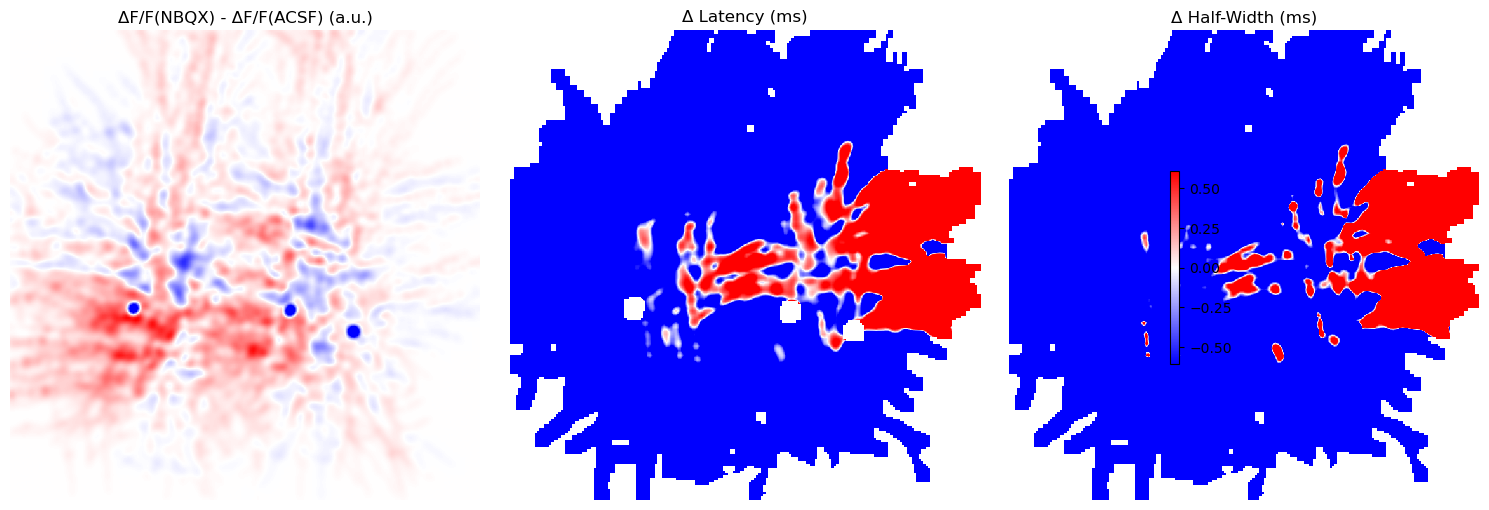

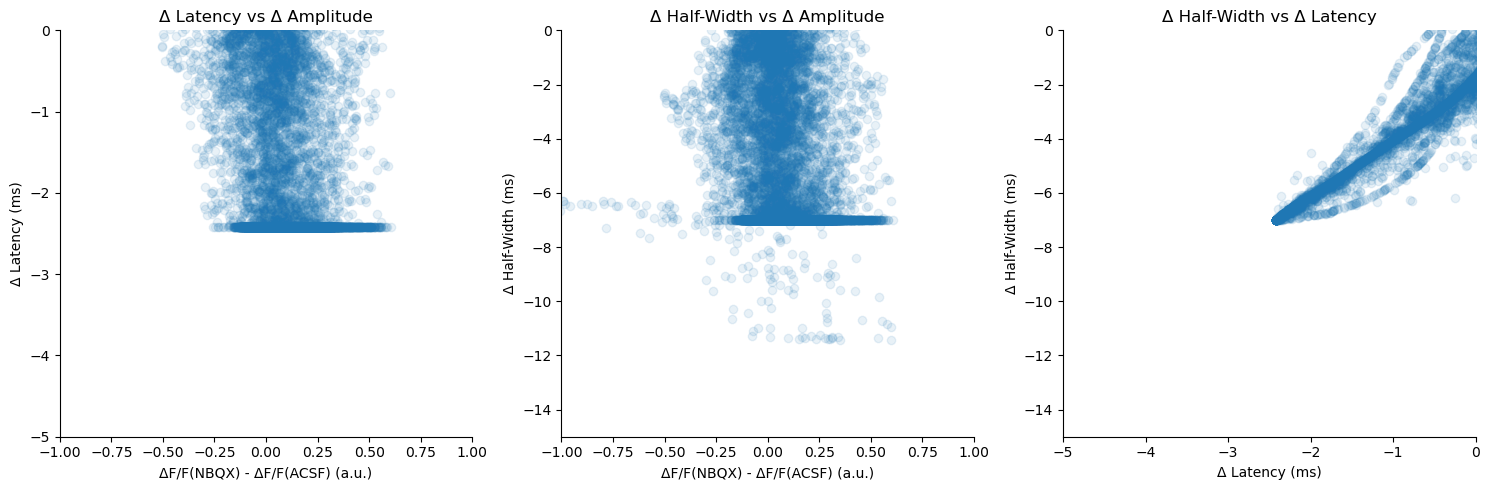

In [14]:

# define Delta = df/f(NBQX) - df/f(ACSF)
delta_amp = amp_arr1 - amp_arr2
delta_latency = latency_map1 - latency_map2
delta_halfwidth = half_width_map1 - half_width_map2

# plot the images of delta amplitude, latency, half-width
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
vmin_both = min(delta_amp.min(), delta_latency.min(), delta_halfwidth.min())
vmax_both = max(delta_amp.max(), delta_latency.max(), delta_halfwidth.max())
print(f'vmin_both: {vmin_both}, vmax_both: {vmax_both}')
im = ax[0].imshow(delta_amp, cmap='bwr', vmin=-1*vmax_both, vmax=vmax_both)
ax[0].set_title('ΔF/F(NBQX) - ΔF/F(ACSF) (a.u.)')
ax[0].axis('off')

im = ax[1].imshow(delta_latency, cmap='bwr', vmin=-1*vmax_both, vmax=vmax_both)
ax[1].set_title('Δ Latency (ms)')
ax[1].axis('off')

im = ax[2].imshow(delta_halfwidth, cmap='bwr', vmin=-1*vmax_both, vmax=vmax_both)
ax[2].set_title('Δ Half-Width (ms)')
ax[2].axis('off')
plt.colorbar(im, ax=ax.ravel().tolist(), shrink=0.5)
plt.tight_layout()
plt.savefig(output_dir + f"delta_images_{data_dir1.split('/')[-2]}_and_{data_dir2.split('/')[-2]}_{comp_select_name}.png")
plt.show()

# correlations between delta amplitude, latency, half-width
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].scatter(delta_amp.flatten(), delta_latency.flatten(), alpha=0.1)
ax[0].set_xlabel('ΔF/F(NBQX) - ΔF/F(ACSF) (a.u.)')
ax[0].set_ylabel('Δ Latency (ms)')
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[0].set_title('Δ Latency vs Δ Amplitude')
ax[0].set_xlim(-1, 1)
ax[0].set_ylim(-5, 0)

ax[1].scatter(delta_amp.flatten(), delta_halfwidth.flatten(), alpha=0.1)
ax[1].set_xlabel('ΔF/F(NBQX) - ΔF/F(ACSF) (a.u.)')
ax[1].set_ylabel('Δ Half-Width (ms)')
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].set_title('Δ Half-Width vs Δ Amplitude')
ax[1].set_xlim(-1, 1)
ax[1].set_ylim(-15, 0)

ax[2].scatter(delta_latency.flatten(), delta_halfwidth.flatten(), alpha=0.1)
ax[2].set_xlabel('Δ Latency (ms)')
ax[2].set_ylabel('Δ Half-Width (ms)')
ax[2].spines['top'].set_visible(False)
ax[2].spines['right'].set_visible(False)
ax[2].set_title('Δ Half-Width vs Δ Latency')
ax[2].set_xlim(-5, 0)
ax[2].set_ylim(-15, 0)
plt.tight_layout()
plt.savefig(output_dir + f"delta_correlations_{data_dir1.split('/')[-2]}_and_{data_dir2.split('/')[-2]}_{comp_select_name}.png")
plt.show()

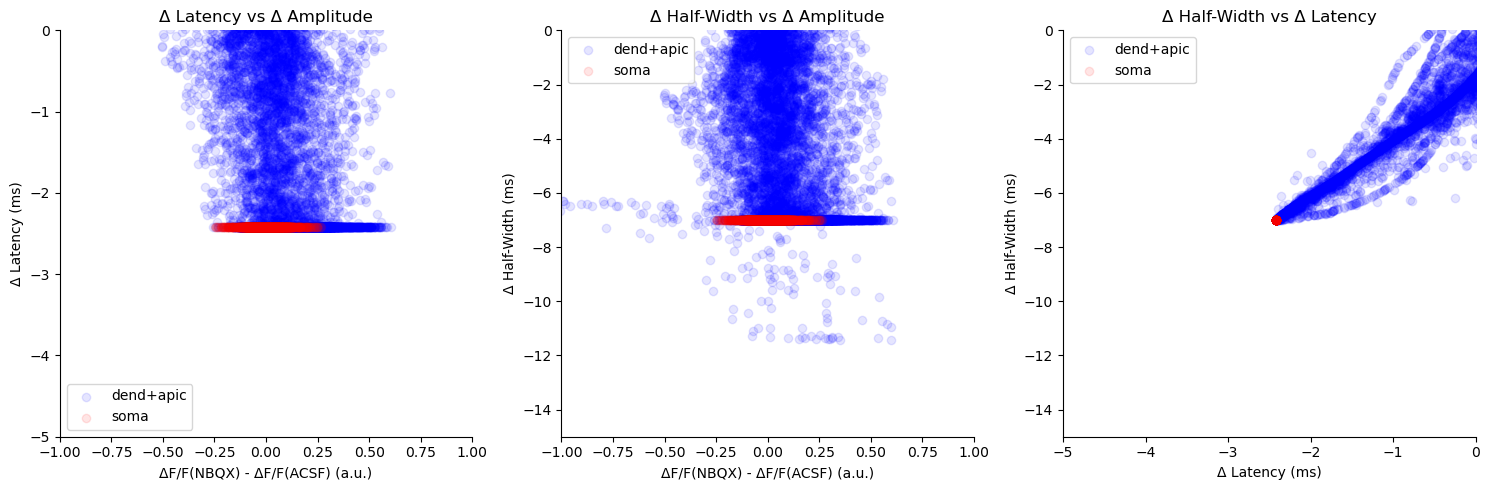

In [15]:
# define Delta = df/f(NBQX) - df/f(ACSF)
delta_amp2 = amp_arr12 - amp_arr22
delta_latency2 = latency_map12 - latency_map22
delta_halfwidth2 = half_width_map12 - half_width_map22

# correlations between delta amplitude, latency, half-width
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].scatter(delta_amp.flatten(), delta_latency.flatten(), alpha=0.1, label=comp_select_label, color='blue')
ax[0].scatter(delta_amp2.flatten(), delta_latency2.flatten(), alpha=0.1, label=comp_select_label2, color='red')
ax[0].legend()
ax[0].set_xlabel('ΔF/F(NBQX) - ΔF/F(ACSF) (a.u.)')
ax[0].set_ylabel('Δ Latency (ms)')
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[0].set_title('Δ Latency vs Δ Amplitude')
ax[0].set_xlim(-1, 1)
ax[0].set_ylim(-5, 0)

ax[1].scatter(delta_amp.flatten(), delta_halfwidth.flatten(), alpha=0.1, label=comp_select_label, color='blue')
ax[1].scatter(delta_amp2.flatten(), delta_halfwidth2.flatten(), alpha=0.1, label=comp_select_label2, color='red')
ax[1].legend()
ax[1].set_xlabel('ΔF/F(NBQX) - ΔF/F(ACSF) (a.u.)')
ax[1].set_ylabel('Δ Half-Width (ms)')
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].set_title('Δ Half-Width vs Δ Amplitude')
ax[1].set_xlim(-1, 1)
ax[1].set_ylim(-15, 0)

ax[2].scatter(delta_latency.flatten(), delta_halfwidth.flatten(), alpha=0.1, label=comp_select_label, color='blue')
ax[2].scatter(delta_latency2.flatten(), delta_halfwidth2.flatten(), alpha=0.1, label=comp_select_label2, color='red')
ax[2].legend()
ax[2].set_xlabel('Δ Latency (ms)')
ax[2].set_ylabel('Δ Half-Width (ms)')
ax[2].spines['top'].set_visible(False)
ax[2].spines['right'].set_visible(False)
ax[2].set_title('Δ Half-Width vs Δ Latency')
ax[2].set_xlim(-5, 0)
ax[2].set_ylim(-15, 0)
plt.tight_layout()
plt.savefig(output_dir + f"delta_correlations_{data_dir1.split('/')[-2]}_and_{data_dir2.split('/')[-2]}_{comp_select_name}_vs_{comp_select_name2}.png")
plt.show()

In [18]:
amp_ratio_arr.shape

(30385,)

Stimulus location in pixel coordinates: (100, 100)


C:\Users\jjudge3\AppData\Local\Temp\ipykernel_31720\4057346397.py:18: RuntimeWarning: divide by zero encountered in true_divide
  amp_ratio_map = amp_arr1 / amp_arr2
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_31720\4057346397.py:18: RuntimeWarning: invalid value encountered in true_divide
  amp_ratio_map = amp_arr1 / amp_arr2


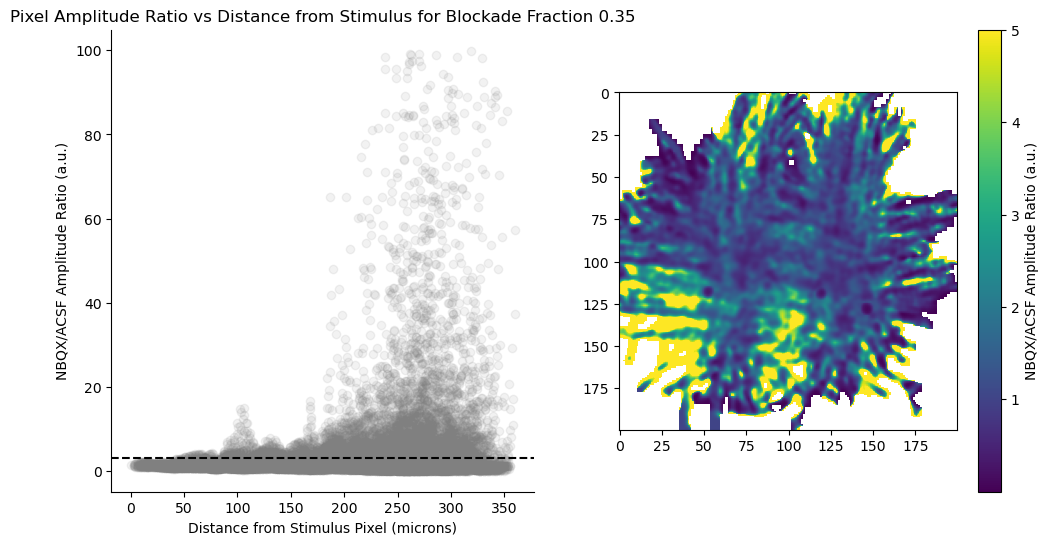

In [28]:
# which pixel is the stim?
fov_center = cam_params['cam_fov'] 
cam_width = cam_params['cam_width']
cam_height = cam_params['cam_height'] 
is_stim_at_cam_center = cam_params['xstim_at_cam_fov']
cam = Camera([], [], [], init_dummy=True, fov_center=fov_center,
             camera_width=cam_width, camera_height=cam_height)  # dummy camera to get pixel coords
stim_loc_pixel = cam.map_point_to_pixel(fov_center[0], fov_center[1], fov_center[2])

print(f'Stimulus location in pixel coordinates: {stim_loc_pixel}')

# plot px amplitude versus distance from stim pixel
px_dist = []
px_amp_ratio = []
um_per_pixel = cam_params['cam_resolution']  # microns per pixel


amp_ratio_map = amp_arr1 / amp_arr2
amp_ratio_map[(amp_arr2 <= 0) | (amp_arr1 <= 0)] = np.nan
amp_ratio_map[amp_ratio_map > 100] = np.nan
amp_ratio_map[amp_ratio_map <= 0] = np.nan

# two subplots
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
plt.subplot(1, 2, 1)
for x in range(amp_arr2.shape[1]):
    for y in range(amp_arr2.shape[0]):
        if amp_arr2[y, x] <= 0:
            continue
        if amp_arr1[y, x] <= 0:
            continue
        amp_ratio = amp_arr1[y, x] / amp_arr2[y, x]
        if np.isnan(amp_ratio) or amp_ratio > 100 or amp_ratio <= 0:
            continue
        pixel_distance = np.sqrt((x - stim_loc_pixel[0])**2 + (y - stim_loc_pixel[1])**2)
        px_dist.append(pixel_distance * um_per_pixel)
        px_amp_ratio.append(amp_ratio)


plt.scatter(px_dist, px_amp_ratio, color='gray', alpha=0.1)

plt.ylabel(f'{label1}/{label2} Amplitude Ratio (a.u.)')
plt.xlabel('Distance from Stimulus Pixel (microns)')
# spines off
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
# horizontal line at amp_ratio = 1
plt.axhline(y=mean_amp_ratio, color='black', linestyle='--', label=f'Mean Ratio = {mean_amp_ratio:.3f}')
plt.title('Pixel Amplitude Ratio vs Distance from Stimulus for Blockade Fraction ' + str(nbqx_fraction))
plt.subplot(1, 2, 2)
plt.imshow(amp_ratio_map, cmap='viridis', vmax=5)
plt.colorbar(label=f'{label1}/{label2} Amplitude Ratio (a.u.)')

plt.savefig(output_dir + f"amplitude_ratio_histogram_{data_dir1.split('/')[-2]}_and_{data_dir2.split('/')[-2]}_{comp_select_name}.png")
plt.show()
plt.close()
